In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax.numpy as jnp
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../')
import field_level.inference as inference
import field_level.coord as coord
import field_level.cosmo_util as cosmo_util
import field_level.power_util as power_util


import numpyro
import numpyro.distributions as dist
from jax import random
from numpyro.infer import MCMC, NUTS
import jax
import jax.scipy as jsp
from jax import jit
#n_chains = 8
#numpyro.set_host_device_count(n_chains)

jax.config.update('jax_enable_x64', True)
numpyro.enable_x64()

print(jax.default_backend())
print(jax.local_devices())

import sys

cpu
[CpuDevice(id=0)]


### Load the mock data and measure its power spectrum

In [3]:
data_root = '/data/kakitsu/field_level/mock_data/'

boxsize = 2000.0
vol = boxsize**3
redshift = 0.5
true_log_Perr = 8.0
true_b1 = 2.0

#mock_signal = np.load(data_root + f'cosmo_{boxsize}_z{redshift}_s1995_gauss_512_768_128.npy')
mock_signal = np.load(data_root + f'cosmo_{boxsize}_z{redshift}_s1995_gauss_rsd_512_768_128_{true_b1}.npy')

mock_noise = np.load(data_root + f'{boxsize}_Gaussian_{true_log_Perr}_128_2006.npy')

mock_data = mock_signal + mock_noise

kbin, pk0, Nk = power_util.power_compute(jnp.array(mock_data), 
                                         jnp.array(mock_data), 
                                         boxsize, nbin=20, kmin=0.0, kmax=0.2)

kbin, pk2, Nk = power_util.power_compute(jnp.array(mock_data), 
                                         jnp.array(mock_data), 
                                         boxsize, nbin=20, kmin=0.0, kmax=0.2,
                                         ell=2)

kbin, pk4, Nk = power_util.power_compute(jnp.array(mock_data), 
                                         jnp.array(mock_data), 
                                         boxsize, nbin=20, kmin=0.0, kmax=0.2,
                                         ell=4)

pk0 = pk0.real
pk2 = pk2.real
pk4 = pk4.real

### Prepare the model

In [6]:
from field_level.forward_model import Forward_Model

#model_name = 'gauss'
model_name = 'gauss_rsd'

which_pk = 'cosmo'
ng = 96
ng_L = int(1.5*ng)
ng_E = 96   ### the Nyquist for this grid (i.e., pi / boxsize * ng_E) should be greater than kmax in the pk analysis to account for the discreteness effect
ng_params = [ng, ng_L, ng_E]

boxsize = 2000.0

kf = 2.*jnp.pi/boxsize
kny = jnp.pi/boxsize*ng

which_space = 'k_space' ### currently no effect

f_model = Forward_Model(model_name, which_pk, ng_params, boxsize, which_space)

f_model.kvecs(0.12)


model =  gauss_rsd


In [7]:
### get the linear matter power spectrum from JAX-CosmoPower

omega_b = 0.02242 ### Omega_b h^2
omega_c = 0.11933 ### Omega_cdm h^2
hubble = 0.73
ns = 0.9665
ln1010As = 3.047
OM0 = (omega_c + omega_b)/hubble/hubble

growth_f = cosmo_util.growth_f_fitting(redshift, OM0)
print('growth_f = ', growth_f)

cosmo_params = [omega_b, 
                omega_c,
                hubble,
                ns,
                ln1010As,
                0.0]   ### for the sigma8 computation

pk_lin = f_model.linear_power(cosmo_params)
true_sigma8 = f_model.sigma8(pk_lin)
print('sigma8 =', true_sigma8)
cosmo_params[-1] = redshift
pk_lin = f_model.linear_power(cosmo_params)


growth_f =  0.7175181128407132


sigma8 = 0.8350423924781688


In [8]:
kmin = 0.0
kmax = 0.12
kbin_data = kbin[kbin<=kmax]
Nk_data = Nk[kbin<=kmax]

pk0_data = pk0[kbin<=kmax]
pk2_data = pk2[kbin<=kmax]
pk4_data = pk4[kbin<=kmax]

nbin = len(kbin_data)
pk_data = jnp.hstack([pk0_data, pk2_data, pk4_data])

### for real space
pk_truth = jnp.interp(kbin_data, pk_lin[0], pk_lin[1])

### Covariance of pk with the discreteness

In [9]:
true_Perr = jnp.exp(true_log_Perr)

### w/ the correction to the discreteness

### for rsd
kaiser =  (true_b1 + growth_f*f_model.mu2_E )**2
pk_3d = kaiser * jnp.interp( jnp.sqrt(f_model.k2_E), pk_lin[0], pk_lin[1] ) + true_Perr  
ellmax = 4

### for real space
#pk_3d = jnp.interp( jnp.sqrt(f_model.k2_E), pk_lin[0], pk_lin[1] ) + true_Perr
#ellmax = 0

cov = power_util.covariance_legendre_compute(pk_3d, boxsize, nbin=nbin, kmin=kmin, kmax=kmax, ellmax=ellmax)

## or w/o the correction to the discreteness
#cov = jnp.diag(jnp.array(2.*(pk_truth + true_Perr)**2/Nk_data))
#cov = jnp.diag(jnp.array(2.*pk_data[:nbin]**2/Nk_data))

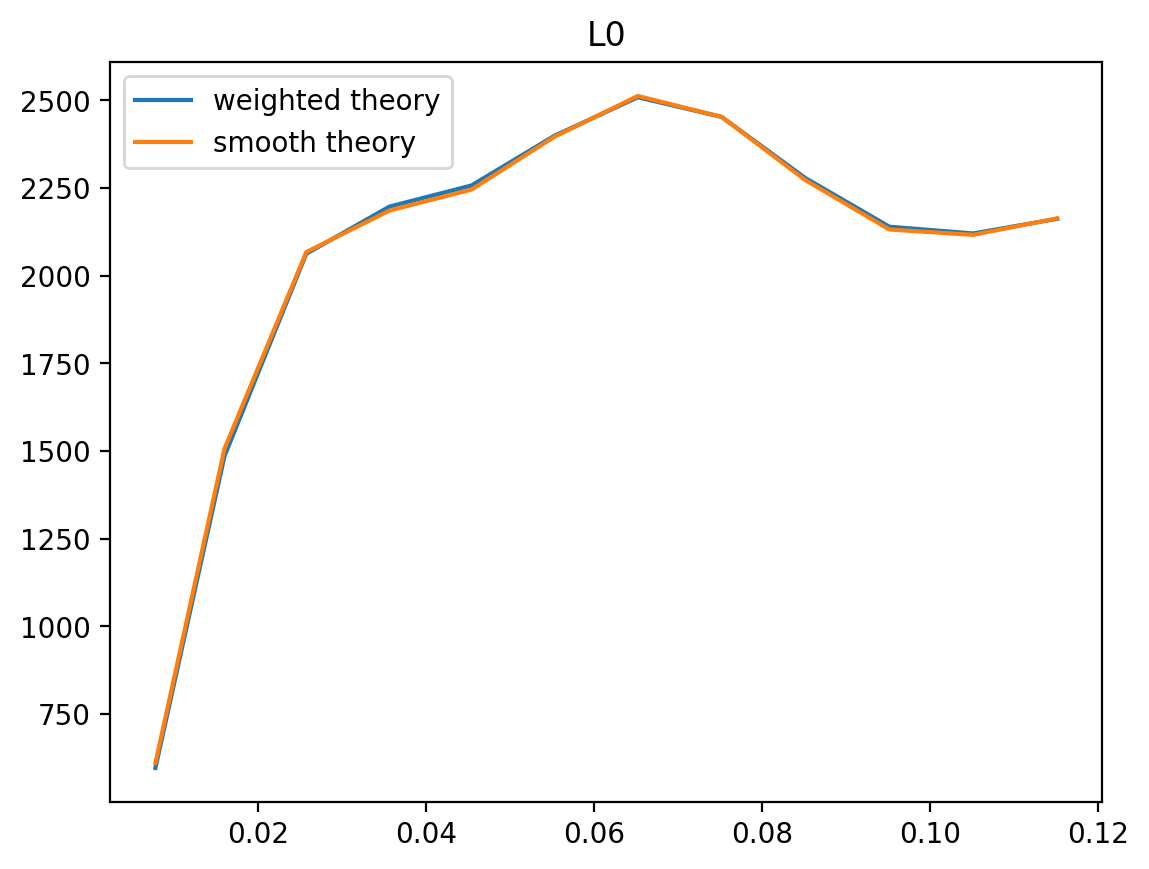

In [10]:
### check the weighted pk 
ellmax = 4

pk_weight = power_util.power_weight_compute(pk_3d, jnp.sqrt(f_model.k2_E), f_model.mu2_E, nbin=nbin, kmin=kmin, kmax=kmax, ellmax=ellmax)

#plt.plot(kbin_data, kbin_data*pk_data[:nbin], label='data')
plt.plot(kbin_data, kbin_data*pk_weight[:nbin], label='weighted theory')
plt.plot(kbin_data, kbin_data*( (true_b1**2 + 2./3.*true_b1*growth_f + 0.2*growth_f**2)*pk_truth[:nbin] + true_Perr), 
         label='smooth theory')
#plt.plot(kbin_data, kbin_data*(pk_truth[:nbin] + true_Perr), 
#         label='smooth theory')


plt.title('L0')
plt.legend()

### Inference

In [11]:
binmax = 3*nbin

print(cov.shape)

def pk_model(pk_data):
    omega_c = numpyro.sample('oc', dist.Uniform(0.05, 0.355))
    #omega_c = 0.11933
    hubble = numpyro.sample('hubble', dist.Uniform(0.64, 0.82))
    #hubble = 0.73
    H0 = numpyro.deterministic('H0', hubble*100)
    OM = numpyro.deterministic('OM', (omega_b + omega_c)/hubble/hubble)
    cosmo_params_local = jnp.array([omega_b, 
                                    omega_c,
                                    hubble,
                                    ns,
                                    ln1010As,
                                    0.0])
    pk_lin = f_model.linear_power(cosmo_params_local)
    ### sampling simga8
    #tmp_sigma8 = f_model.sigma8(pk_lin, type_integ='trap')
    #sigma8 = numpyro.sample('sigma8', dist.Uniform(true_sigma8*0.5, true_sigma8*1.5))
    #A = numpyro.deterministic('A', sigma8/tmp_sigma8)
    
    ### or sampling A
    A = numpyro.sample('A', dist.Uniform(0.5, 1.5))
    sigma8 = numpyro.deterministic('sigma8', A * f_model.sigma8(pk_lin, type_integ='trap'))
    #A = 1.0
    A2 = A*A
    
    cosmo_params_local = cosmo_params_local.at[-1].set(redshift)
    pk_lin = f_model.linear_power(cosmo_params_local)
    pk_lin = pk_lin.at[1].multiply(A2)

    log_Perr = numpyro.sample("log_Perr", dist.Normal(true_log_Perr, 0.5))
    #log_Perr = 8.0
    Perr = jnp.exp(log_Perr)
    
    ### bias
    b1 = numpyro.sample('b1', dist.Uniform(1.0, 4.0))
    #b1 = 2.0
    growth_f = numpyro.deterministic('growth_f', cosmo_util.growth_f_fitting(redshift, OM) )
    
    ### pk at bin averaged k
    #model_pk = jnp.interp(kbin_data, pk_lin[0], pk_lin[1])
    #model_pk0 = model_pk
    #model_pk2 = jnp.zeros_like(model_pk0)
    #model_pk4 = jnp.zeros_like(model_pk0)
    
    #model_pk0 = (b1**2 + 2./3.*b1*growth_f + 1./5.*growth_f**2)*model_pk
    #model_pk2 = (4./3.*b1*growth_f + 4./7.*growth_f**2)*model_pk
    #model_pk4 = 8./35.*growth_f**2*model_pk
    
    #pk_model = jnp.hstack([model_pk0 + Perr, 
    #                       model_pk2,
    #                       model_pk4])
    
    ### weighted pk
    kaiser =  (b1 + growth_f*f_model.mu2_E )**2
    pk_3d = kaiser * jnp.interp( jnp.sqrt(f_model.k2_E), pk_lin[0], pk_lin[1] ) + Perr  
    pk_model = power_util.power_weight_compute(pk_3d, 
                                               jnp.sqrt(f_model.k2_E), 
                                               f_model.mu2_E, 
                                               nbin=nbin, kmin=kmin, kmax=kmax, ellmax=ellmax)
    
    #Y = numpyro.sample('Y', dist.Normal(pk_model[:binmax], jnp.sqrt(jnp.diag(cov[:binmax,:binmax])) ), obs=pk_data[:binmax])
    Y = numpyro.sample('Y', dist.MultivariateNormal(loc=pk_model[:binmax], covariance_matrix=cov[:binmax,:binmax]), obs=pk_data[:binmax])
    #Y = numpyro.sample('Y', dist.MultivariateNormal(loc=pk_model[:binmax], precision_matrix=precision_mat[:binmax,:binmax]), obs=pk_data[:binmax])


(36, 36)


In [12]:
accept_rate = 0.8

kernel = numpyro.infer.NUTS(model=pk_model,
                            target_accept_prob=accept_rate,
                            adapt_step_size=True,
                            adapt_mass_matrix=True,
                            max_tree_depth=(8, 8),
                            init_strategy=numpyro.infer.init_to_sample)


mcmc = numpyro.infer.MCMC(kernel,
                          num_samples=3000,
                          num_warmup=500,
                          num_chains=3,
                          thinning=1,
                          chain_method="vectorized",
                          progress_bar=True)



In [13]:
posterior = {}

mcmc_seed = 1995
rng_key = jax.random.PRNGKey(mcmc_seed)
mcmc.run(rng_key, pk_data=pk_data[:binmax], extra_fields=('potential_energy',))



warmup:   1%|          | 30/3500 [02:07<4:06:40,  4.27s/it]


KeyboardInterrupt: 

In [ ]:
posterior['pow_weighted_grid_cov_sspace_L4_0.12_double'] = mcmc.get_samples(group_by_chain=True)


In [14]:
import pickle
posterior = {}

with open('/home/kakitsu/field_level/field_level/analysis/samples/linear_pk_pow_weighted_grid_cov_sspace_L4_0.12_double.pkl', 'rb') as f:
    posterior['pow_weighted_grid_cov_sspace_L4_0.12_double'] = pickle.load(f)

In [12]:
for weight in ['_data_cov', '_analytic_cov']:
    for ell in ['_L0',]:
        with open(f'/home/kakitsu/field_level/field_level/analysis/samples/linear_pk{weight}_rspace{ell}.pkl','rb') as f:
            posterior[f'pow{weight}{ell}'] = pickle.load(f)

In [14]:
import pickle

#posterior = {}

for weight in ['', '_weighted']:
    for ell in ['_L2', '_L4']:
        for cov in ['_grid_cov']:
            with open(f'/home/kakitsu/field_level/field_level/analysis/samples/linear_pk{weight}{cov}_sspace{ell}.pkl','rb') as f:
                posterior[f'pow{weight}{cov}{ell}'] = pickle.load(f)

/home/kakitsu/python/jax0423_env39/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'oc'}>, <Axes: title={'center': 'oc'}>],
       [<Axes: title={'center': 'hubble'}>,
        <Axes: title={'center': 'hubble'}>],
       [<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'OM'}>, <Axes: title={'center': 'OM'}>],
       [<Axes: title={'center': 'b1'}>, <Axes: title={'center': 'b1'}>],
       [<Axes: title={'center': 'log_Perr'}>,
        <Axes: title={'center': 'log_Perr'}>]], dtype=object)

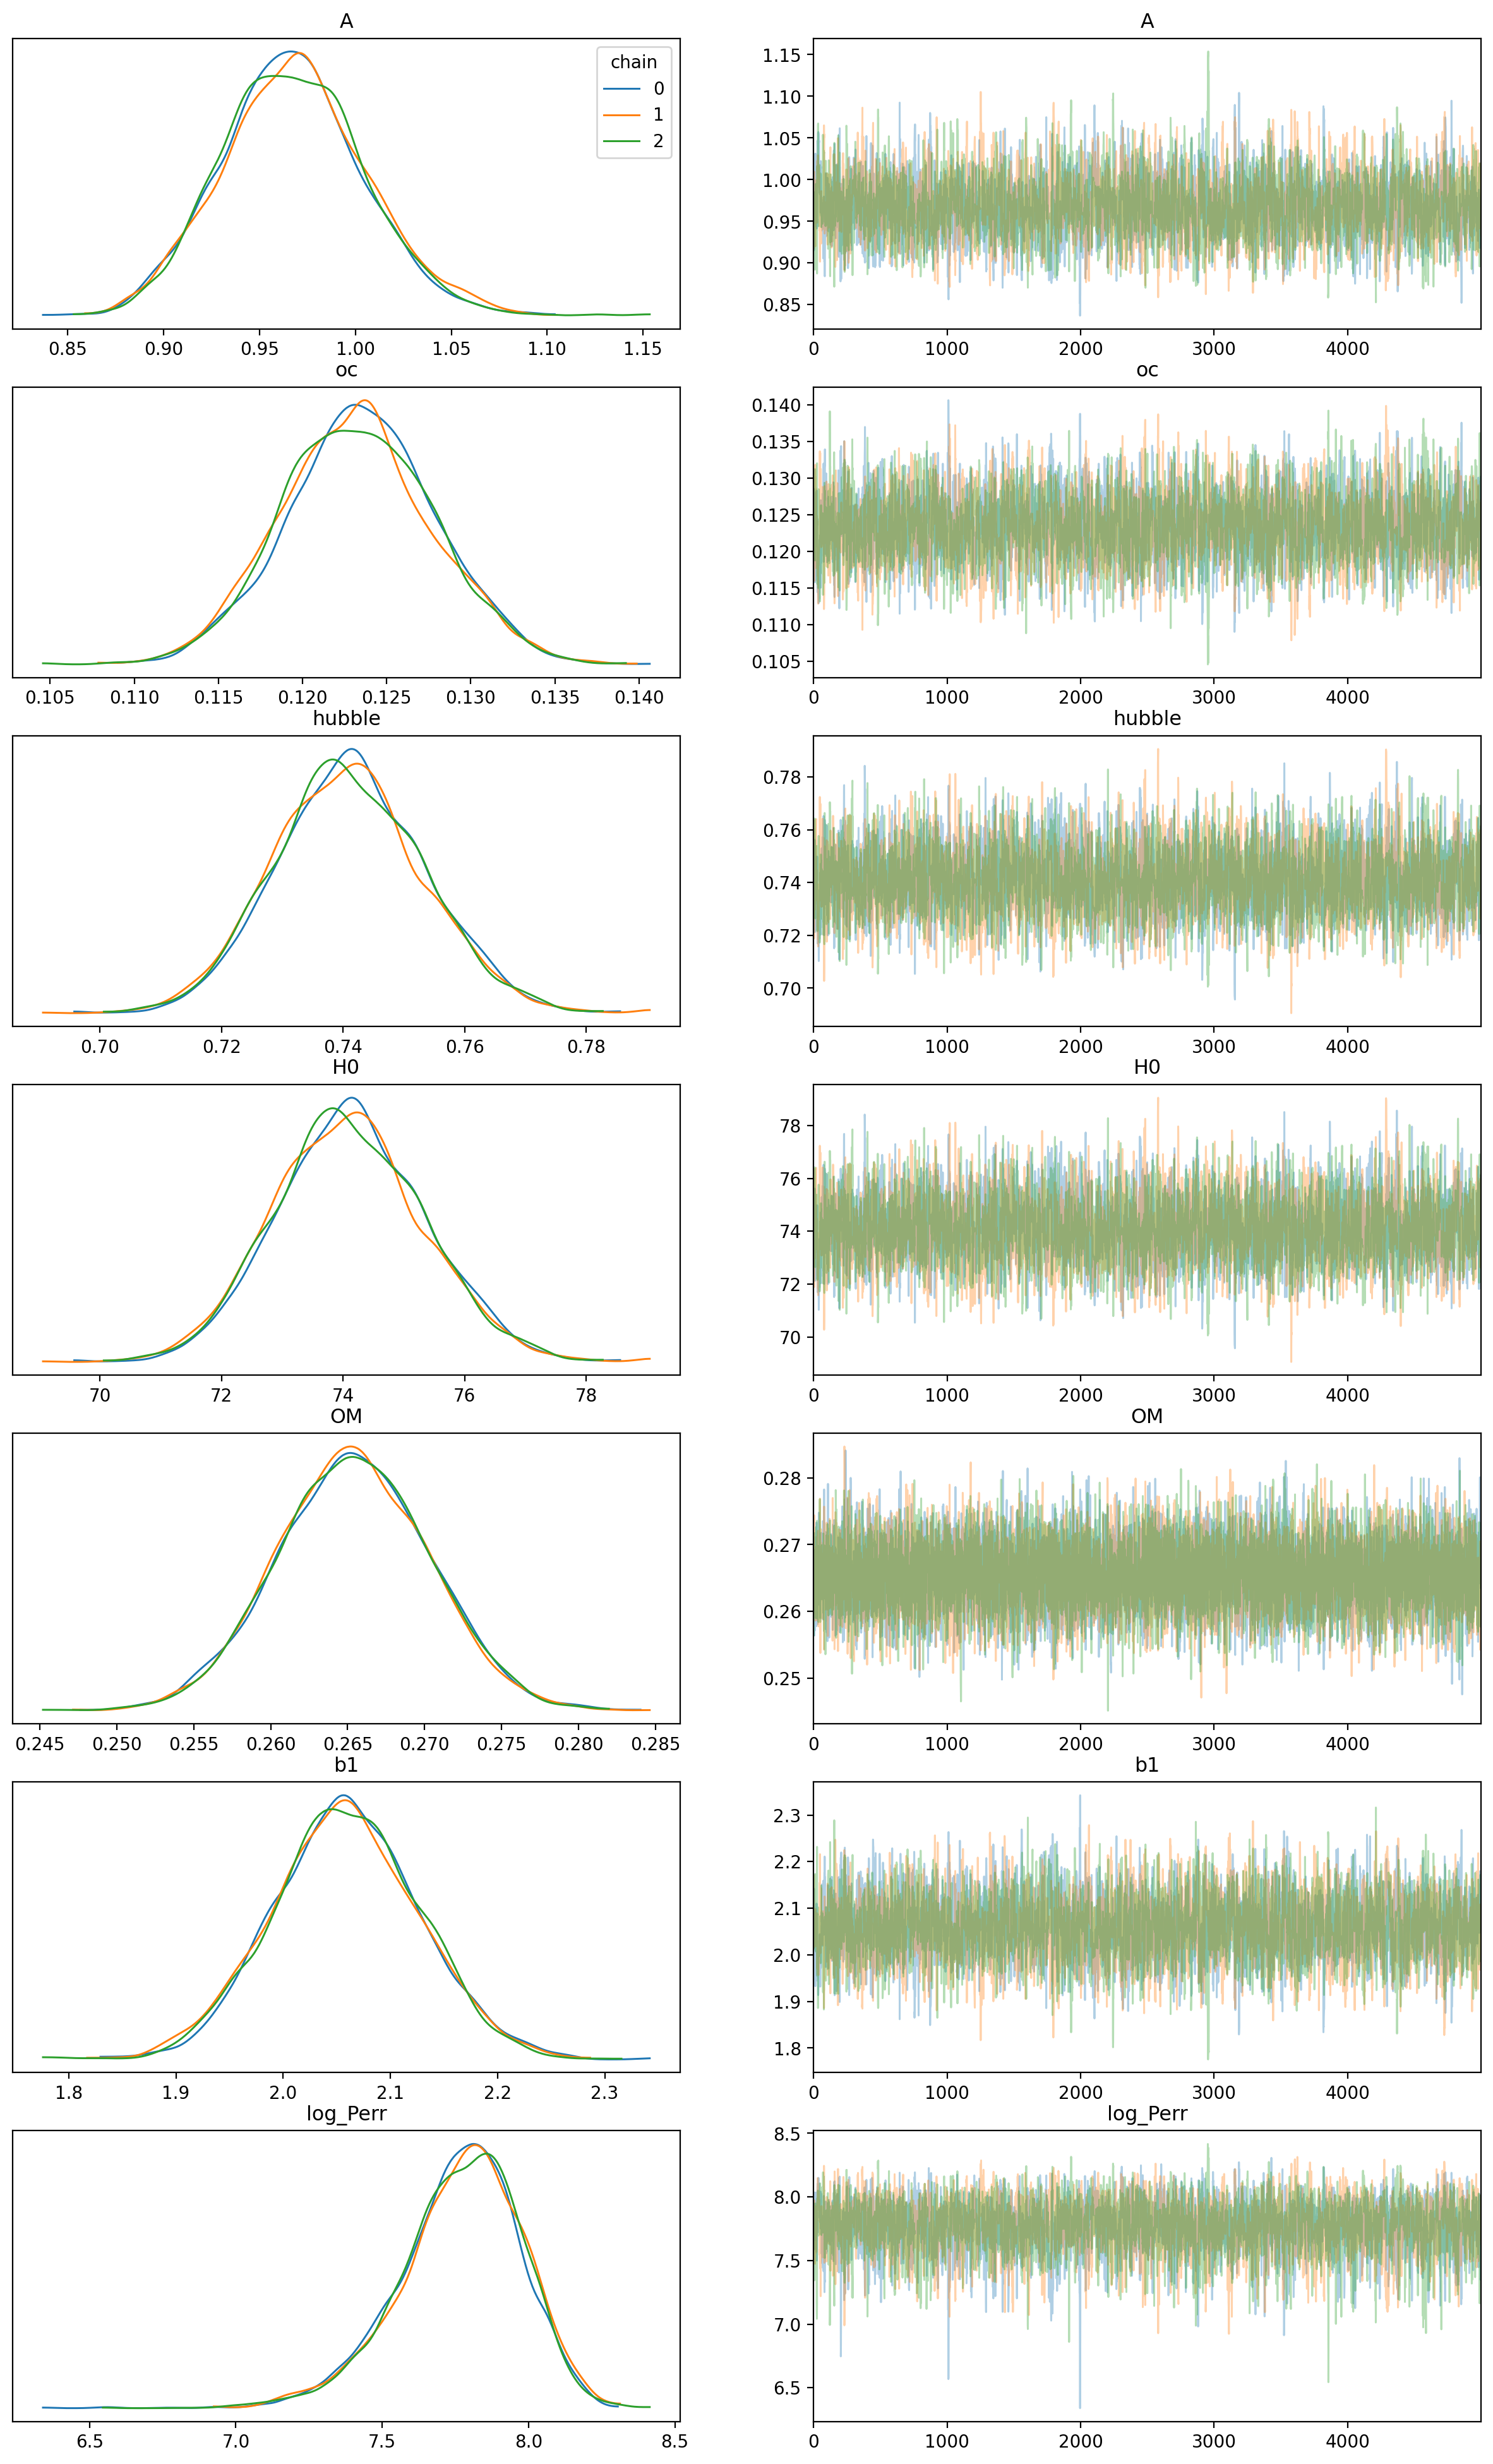

In [15]:
%matplotlib inline

import arviz as az

params_pow = ['A', 'oc', 'hubble', 'H0', 'OM', 'b1', 'log_Perr']
#params_pow = [ 'oc', 'hubble', 'H0', 'OM', 'b1', 'log_Perr']
#params_pow = ['A', 'sigma8', 'oc', 'hubble', 'H0', 'OM',]
#params_pow = ['A', 'sigma8', 'oc', 'OM',]
#params_pow = ['A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'log_Perr']
#params_pow = ['A', 'sigma8', 'oc', 'OM', 'log_Perr']
#params_pow = ['A', 'H0', 'log_Perr']

az.plot_trace(posterior['pow_weighted_grid_cov_sspace_L4_0.12_double'], 
              var_names=params_pow,
              legend=True,
              compact=False,
              figsize=(15, 3.5*len(params_pow)),
              coords={'chain':[0,1,2,]})

In [18]:
az.summary(posterior['pow_weighted_grid_cov_sspace_L4_0.12_double'],
           var_names=params_pow,
           round_to=10,
           coords={"chain":[0,1,2]})

mean        sd     hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
A          0.967552  0.037257   0.898988   1.039219   0.000745  0.000527   
oc         0.123328  0.004488   0.114901   0.131782   0.000091  0.000064   
hubble     0.741074  0.012291   0.718239   0.764180   0.000229  0.000162   
H0        74.107387  1.229134  71.823926  76.418015   0.022900  0.016207   
OM         0.265380  0.004954   0.256255   0.274831   0.000049  0.000035   
b1         2.058342  0.068481   1.933711   2.190516   0.001275  0.000902   
log_Perr   7.764903  0.208929   7.360545   8.131520   0.004198  0.002969   

              ess_bulk      ess_tail     r_hat  
A          2487.563290   3002.689517  1.001175  
oc         2456.085323   3591.648245  1.001719  
hubble     2892.567436   4592.129962  1.001433  
H0         2892.567436   4592.129962  1.001433  
OM        10028.276798  10208.616297  0.999983  
b1         2890.627197   3954.593801  1.000693  
log_Perr   2548.234350   3065.356572  1.001163

### Load the samples of the field-level

In [19]:
root_data = '/data/kakitsu/field_level'

def name_to_label(param_name):
    if param_name == 'A':
        return 'A'
    if param_name == 'sigma8':
        return '\sigma_8'
    if param_name == 'hubble':
        return 'h'
    if param_name == 'H0':
        return 'H_0'
    if param_name == 'oc':
        return r'\omega_{\rm cdm}'
    if param_name == 'OM':
        return r'\Omega_{\rm m}'
    if param_name == 'log_Perr':
        return r'\mathrm{log}(P_{\rm err})'
    if param_name == 'b1':
        return r'b_1'
    if param_name == 'b2':
        return r'b_2'
    if param_name == 'bG2':
        return r'b_{\mathcal{G}_2}'
    if param_name == 'bGamma3':
        return r'b_{\Gamma_3}'
    if param_name == 'cs2':
        return r'c_s^2'
    if param_name == 'c1':
        return r'c_1'
    if param_name == 'growth_f':
        return r'f'
    if param_name == 'Sigma2':
        return r'\Sigma^2'
    if param_name == 'Sigma2_mu2':
        return r'\Sigma_{\mu^2}^2'

In [20]:
### common params

which_ics = 'varied_ics'
which_pk = 'cosmo'

boxsize = 2000.0
redshift = 0.5

seed = 1995

ng_data = 512
ng = 128
ng_L = int(1.5*ng)

ng_E = 128
ngs_data = [ng_data, int(1.5*ng_data), ng_E]

MAS = ''
bias_params = ''

err_type = 'Gaussian'
true_log_Perr = 8.0
seed_n = 2006
err_data_name = f'{err_type}_{true_log_Perr}_{ng_E}_{seed_n}'

accept_rate = 0.8

cosmo_params_keys = ['A', 'sigma8', 'oc', 'hubble', 'H0', 'OM']
err_params_keys = ['log_Perr']
bias_params_keys = ['b1', 'b2', 'bG2', 'bGamma3', 'cs2', 'c1']
stat_params_keys = ['potential_energy']

chains = [0,1,2]

markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'log_Perr':8.0}

In [21]:
which_ics = 'varied_ics'
which_pk = 'cosmo'

boxsize = 2000.0
redshift = 0.5
kmax = 0.12

seed = 1995
#data_model = 'gauss'
#model_name = 'gauss'

data_model = 'gauss_rsd'
model_name = 'gauss_rsd'


ng_data = 512
ng = 128
ng_L = int(1.5*ng)

ng_E = 128
ngs_data = f'{ng_data}_{int(1.5*ng_data)}_{ng_E}'
ngs_name = f'{ng}_{int(1.5*ng)}_{ng_E}'

MAS = ''
bias_params = ''
b1 = 2.0
bias_params = f'_{b1}'


data_name = f'{which_pk}_{boxsize}_z{redshift}_s{seed}_{data_model}_{ngs_data}{MAS}{bias_params}'

#bias_name = ''
bias_name = '_b1'

#dense_mass_names = ['A_oc_hubble_log_Perr',]
dense_mass_names = ['A_oc_hubble_b1_log_Perr',]
#dense_mass_names = ['A_oc_log_Perr', 'A']
#dense_mass_names = ['A_hubble_log_Perr', 'A']
#dense_mass_names = ['A_oc_log_Perr', 'A']

#dense_mass_names = ['A',]

for amp in ['A',]:
    cosmo_name = f'_{amp}_oc_hubble'
    #cosmo_name = f'_{amp}_oc'
    #cosmo_name = f'_{amp}_hubble'
    for err_name in ['_log_Perr',]:
        params = []
        params += stat_params_keys
        params += cosmo_params_keys
        #params += ['A', 'sigma8', 'oc', 'OM']
        #params += ['A', 'sigma8', 'hubble', 'H0', 'OM']
        ### for bias
        params += ['b1']
        if not 'fixed' in err_name:
            params += err_params_keys
        for dense_mass_name in dense_mass_names:
            if 'fixed_log_Perr' in err_name and len(dense_mass_name) > 1:
                dense_mass_name = dense_mass_name[:-9]
                err_name = ''
            if 'sigma8' in amp:
                dense_mass_name = 'sigma8' + dense_mass_name[1:]
            print('dense_mass_name =', dense_mass_name)
            name_base = f'{data_name}_{err_data_name}_{model_name}_{ngs_name}{MAS}{cosmo_name}{bias_name}{err_name}_{dense_mass_name}_{kmax}_{accept_rate}'
            path_base = f'{root_data}/{which_ics}/{name_base}'
            print('params =',params)
            print('name_base =',name_base)
            posterior[f'{name_base}'] = {}
            for param in params:
                #print(param)
                for i_chain in chains:
                    if i_chain == 0 :
                        posterior[f'{name_base}'][param] = np.loadtxt(f'{path_base}_{param}_chain{i_chain}.dat')
                    else:
                        tmp = np.loadtxt(f'{path_base}_{param}_chain{i_chain}.dat')
                        posterior[f'{name_base}'][param] = np.vstack([posterior[f'{name_base}'][param], tmp])
            print(posterior[f'{name_base}'].keys())
            print('')

dense_mass_name = A_oc_hubble_b1_log_Perr
params = ['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'b1', 'log_Perr']
name_base = cosmo_2000.0_z0.5_s1995_gauss_rsd_512_768_128_2.0_Gaussian_8.0_128_2006_gauss_rsd_128_192_128_A_oc_hubble_b1_log_Perr_A_oc_hubble_b1_log_Perr_0.12_0.8
dict_keys(['potential_energy', 'A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'b1', 'log_Perr'])



/home/kakitsu/python/jax0423_env39/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


array([[<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'sigma8'}>,
        <Axes: title={'center': 'sigma8'}>],
       [<Axes: title={'center': 'oc'}>, <Axes: title={'center': 'oc'}>],
       [<Axes: title={'center': 'hubble'}>,
        <Axes: title={'center': 'hubble'}>],
       [<Axes: title={'center': 'H0'}>, <Axes: title={'center': 'H0'}>],
       [<Axes: title={'center': 'OM'}>, <Axes: title={'center': 'OM'}>],
       [<Axes: title={'center': 'log_Perr'}>,
        <Axes: title={'center': 'log_Perr'}>]], dtype=object)

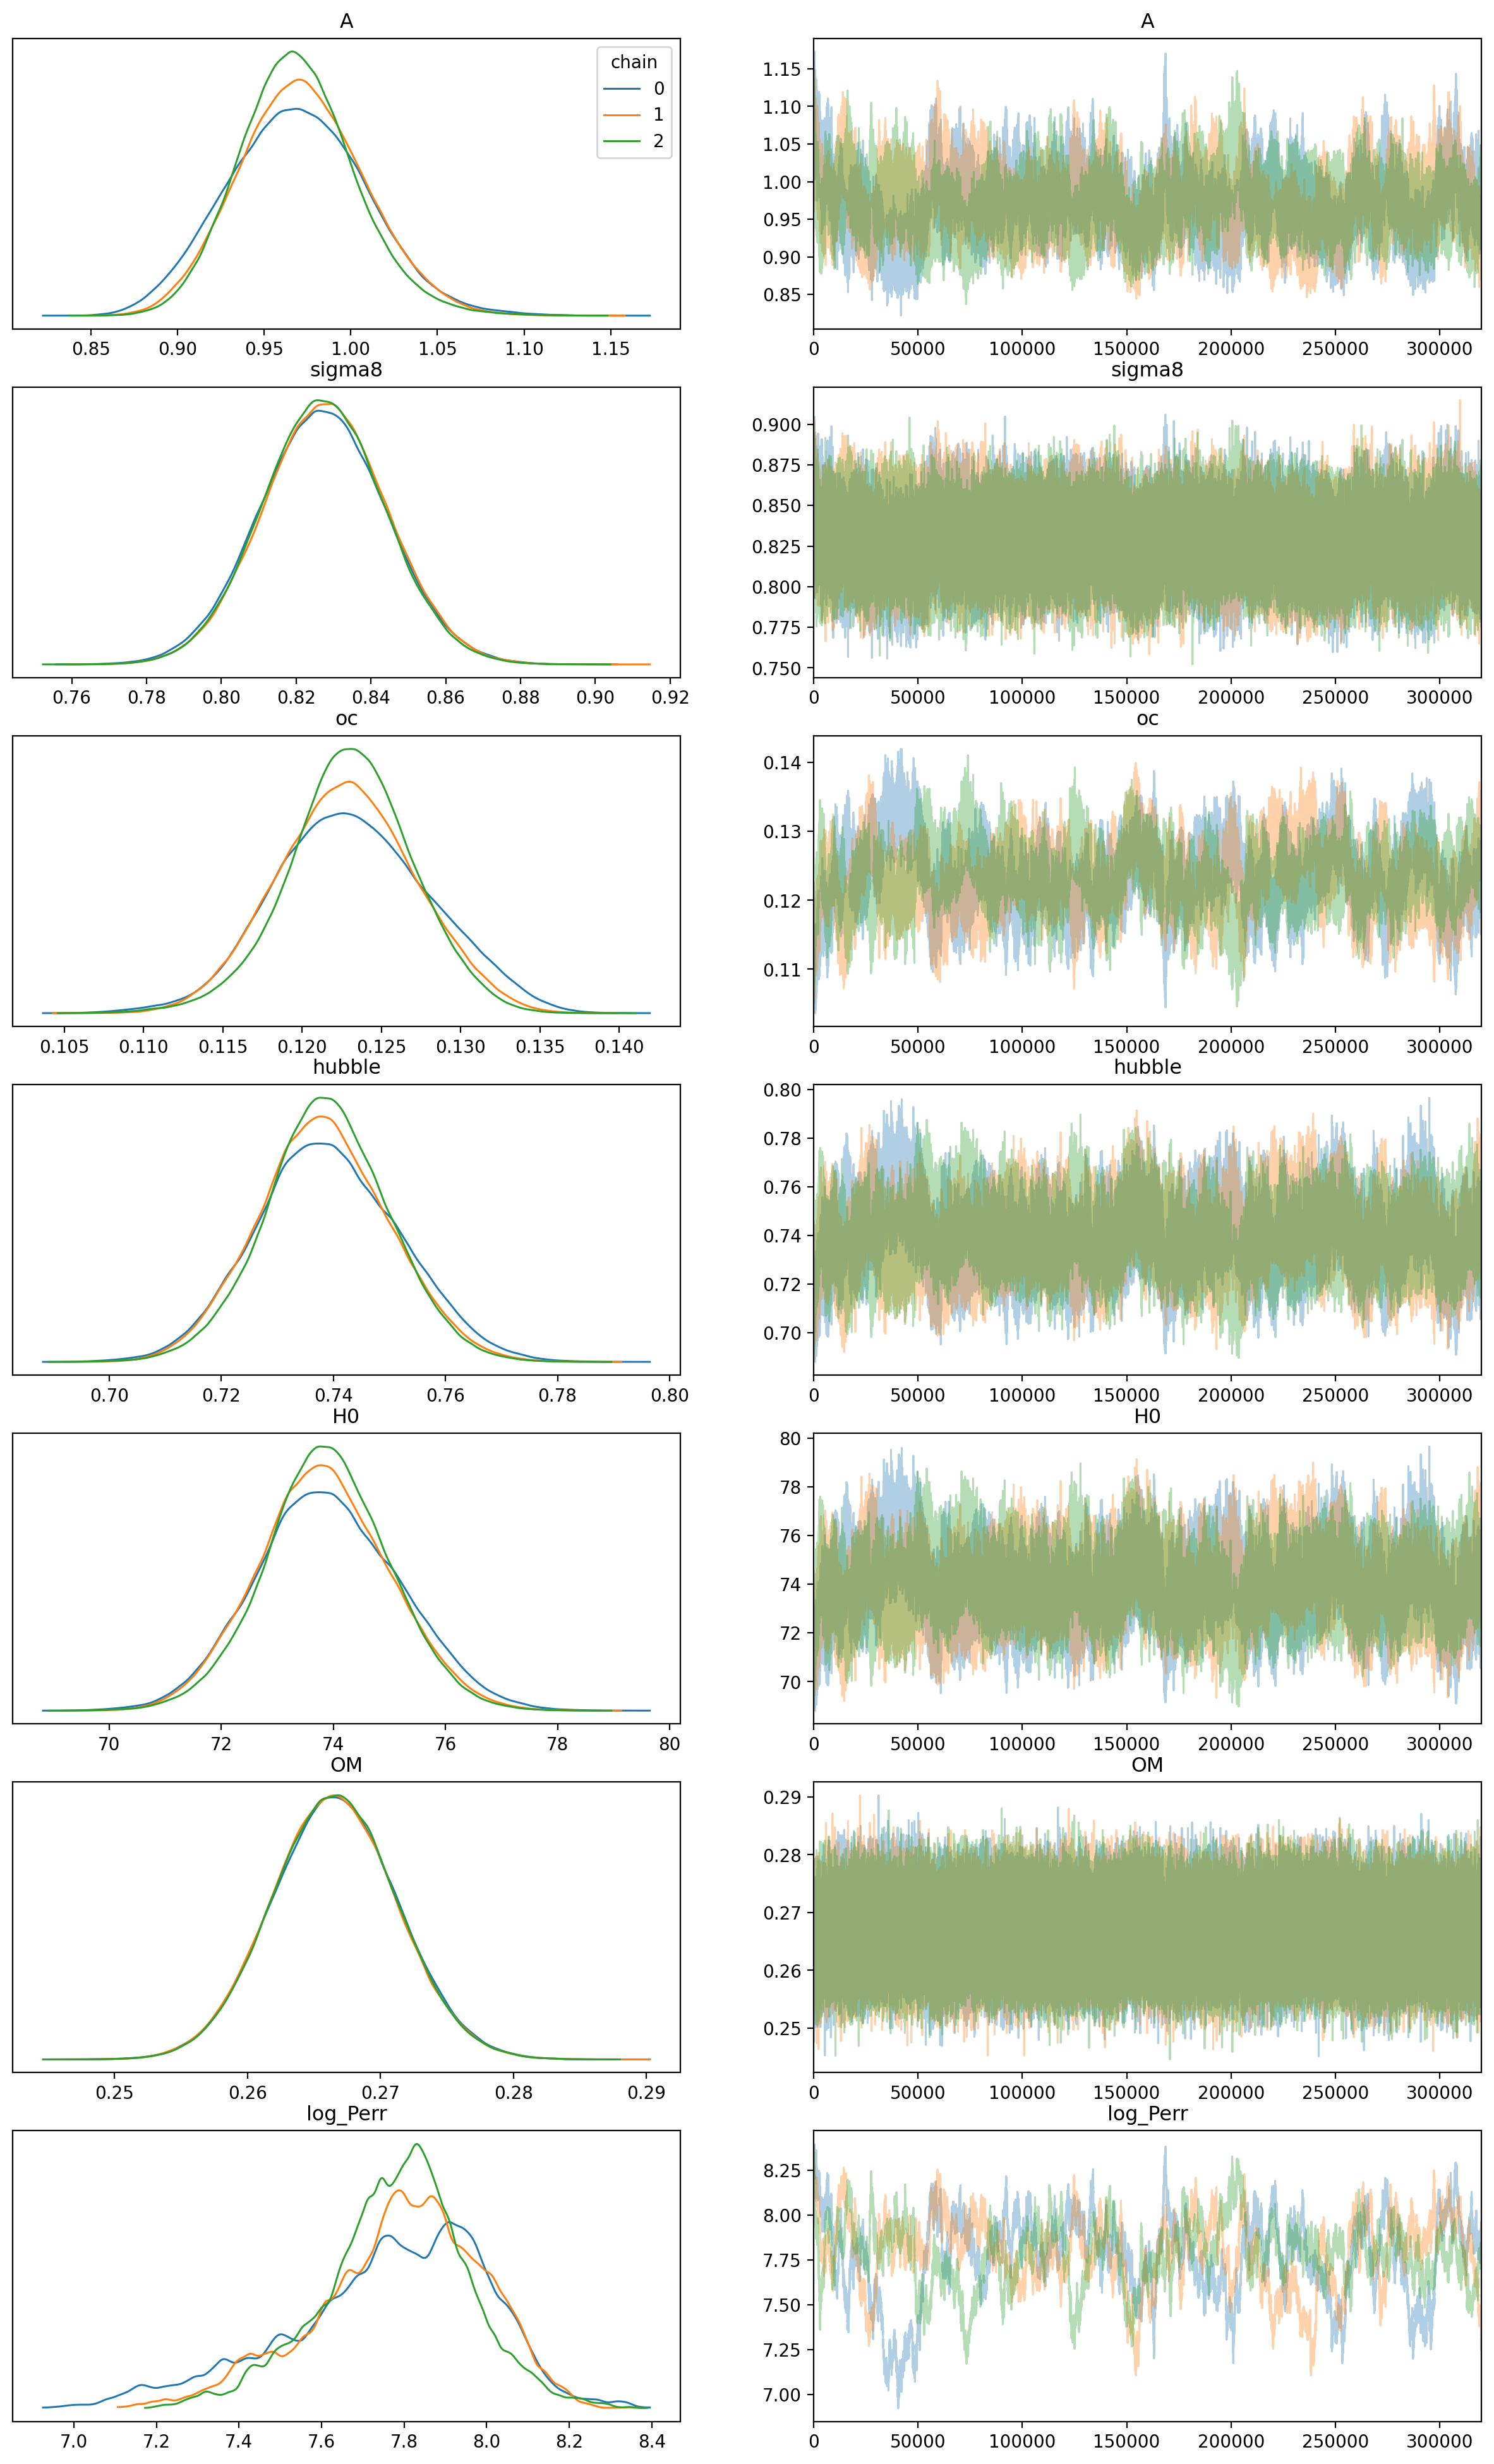

In [22]:
#cosmo_name = '_sigma8_oc_hubble'
cosmo_name = '_A_oc_hubble'
#cosmo_name = '_A_oc'
#cosmo_name = '_A_hubble'

#err_name = ''
err_name = '_log_Perr'

params = []
params += cosmo_params_keys
#params +=  ['A', 'sigma8', 'hubble', 'H0', 'OM']
#params +=  ['A', 'sigma8', 'oc', 'OM']

#dense_mass_name = 'A_oc_hubble_log_Perr'
#dense_mass_name = 'A_oc_log_Perr'
#dense_mass_name = 'A_hubble_log_Perr'

#dense_mass_name = 'A_oc_hubble_b1_log_Perr'
dense_mass_name = 'A_oc_hubble_b1_log_Perr'


if 'sigma8' in cosmo_name:
    dense_mass_name = 'sigma8' + dense_mass_name[1:]
if err_name == '':
    dense_mass_name = dense_mass_name[:-9]
else:
    params += err_params_keys

name_base = f'{data_name}_{err_data_name}_{model_name}_{ngs_name}{MAS}{cosmo_name}{bias_name}{err_name}_{dense_mass_name}_{kmax}_{accept_rate}'

az.plot_trace(posterior[f'{name_base}'], 
              var_names=params,
              legend=True,
              compact=False,
              figsize=(15, 3.5*len(params)),
              coords={'chain':[0,1,2]})

In [23]:
az.summary(posterior[f'{name_base}'],
           var_names=params,
           round_to=10,
           coords={"chain":[0,1,2,]})
           #coords={"chain":[1,2,]})

mean        sd     hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
A          0.970007  0.036797   0.901090   1.039367   0.002825  0.002001   
sigma8     0.827308  0.016616   0.796311   0.858849   0.000607  0.000429   
oc         0.123038  0.004437   0.114750   0.131541   0.000375  0.000268   
hubble     0.738757  0.011942   0.716746   0.761819   0.000830  0.000589   
H0        73.875726  1.194232  71.674553  76.181892   0.083001  0.058925   
OM         0.266509  0.004729   0.257626   0.275410   0.000071  0.000050   
log_Perr   7.776650  0.208188   7.358169   8.139420   0.020642  0.014638   

             ess_bulk      ess_tail     r_hat  
A          164.982772    277.954481  1.008110  
sigma8     748.549765   2951.627692  1.000887  
oc         140.700621    201.470119  1.013183  
hubble     208.917888    427.161956  1.005487  
H0         208.917879    427.161956  1.005487  
OM        4486.690848  24625.254799  1.000145  
log_Perr   111.516968    125.643196  1.026650

In [28]:
from getdist import plots, MCSamples
import getdist

dense_mass_name = 'A_oc_hubble_b1_log_Perr'
#dense_mass_name = 'A_oc_hubble_log_Perr'

samples = {}

for cosmo_name in ['_A_oc_hubble', ]:
    #for err_name in ['',]:
    for err_name in ['_log_Perr',]:
        params = []
        params += cosmo_params_keys
        #params += ['A', 'sigma8', 'hubble', 'H0', 'OM']
        #params += ['A', 'sigma8', 'oc', 'OM']
        params += ['b1']
        if 'sigma8' in cosmo_name:
            dense_mass_name = 'sigma8' + dense_mass_name[1:]
        if err_name == '':
            dense_mass_name = dense_mass_name[:-9]
        else:
            params += err_params_keys
        labels = []
        for param in params:
            labels += [name_to_label(param)]
        name_base = f'{data_name}_{err_data_name}_{model_name}_{ngs_name}{MAS}{cosmo_name}{bias_name}{err_name}_{dense_mass_name}_{kmax}_{accept_rate}'
        tmp = np.array(list(posterior[f'{name_base}'].values()))
        tmp = tmp[:,:2,:]
        print('tmp_shape =', tmp.shape)
        tmp = tmp.reshape(tmp.shape[0],
                          tmp.shape[1]*tmp.shape[2])
        print(tmp[1:,].shape)
        print(name_base)
        print(params)
        print(labels)
        samples[f'{name_base}'] = MCSamples(samples=tmp[1:,].T,
                                            names = params, 
                                            labels=labels,
                                            label = f'field level')

cov = '_grid_cov_sspace'

for weight in ['_weighted']:
    if weight == '_weighted':
        str_label = 'weighted model '
    else:
        str_label = ''
    for ell in ['_L4']:
        str_label += ell[1:]
        tmp_dict = {}
        for key in params:
            tmp_dict[key] = posterior[f'pow{weight}{cov}{ell}_{kmax}_double'][key]

        samps_arr = np.array(list(tmp_dict.values()))
        samps_arr = samps_arr.reshape(samps_arr.shape[0],
                                      samps_arr.shape[1]*samps_arr.shape[2])

        samples[f'pow{weight}{cov}{ell}'] = MCSamples(samples=samps_arr.T,
                                                names=params,
                                                labels=labels,
                                                label=f'power spectrum')


tmp_shape = (9, 2, 320000)
(8, 640000)
cosmo_2000.0_z0.5_s1995_gauss_rsd_512_768_128_2.0_Gaussian_8.0_128_2006_gauss_rsd_128_192_128_A_oc_hubble_b1_log_Perr_A_oc_hubble_b1_log_Perr_0.12_0.8
['A', 'sigma8', 'oc', 'hubble', 'H0', 'OM', 'b1', 'log_Perr']
['A', '\\sigma_8', '\\omega_{\\rm cdm}', 'h', 'H_0', '\\Omega_{\\rm m}', 'b_1', '\\mathrm{log}(P_{\\rm err})']
Removed no burn in
Removed no burn in


In [29]:
tmp_dict = {}
for key in params:
    tmp_dict[key] = posterior[f'pow_weighted_grid_cov_sspace_L4_0.12_double'][key]

samps_arr = np.array(list(tmp_dict.values()))
samps_arr = samps_arr.reshape(samps_arr.shape[0],
                              samps_arr.shape[1]*samps_arr.shape[2])

samples[f'pow_weighted_grid_cov_sspace_L4_0.12_double'] = MCSamples(samples=samps_arr.T,
                                         names=params,
                                         labels=labels,
                                         label=f'power spectrum')


Removed no burn in


In [26]:
tmp_dict = {}
for key in params:
    tmp_dict[key] = posterior[f'pow_weighted_grid_cov_sspace_L4_0.1_double'][key]

samps_arr = np.array(list(tmp_dict.values()))
samps_arr = samps_arr.reshape(samps_arr.shape[0],
                              samps_arr.shape[1]*samps_arr.shape[2])

samples[f'pow_weighted_grid_cov_sspace_L4_0.1_double'] = MCSamples(samples=samps_arr.T,
                                         names=params,
                                         labels=labels,
                                         label=f'double precision')


Removed no burn in


<Figure size 2000x2000 with 0 Axes>

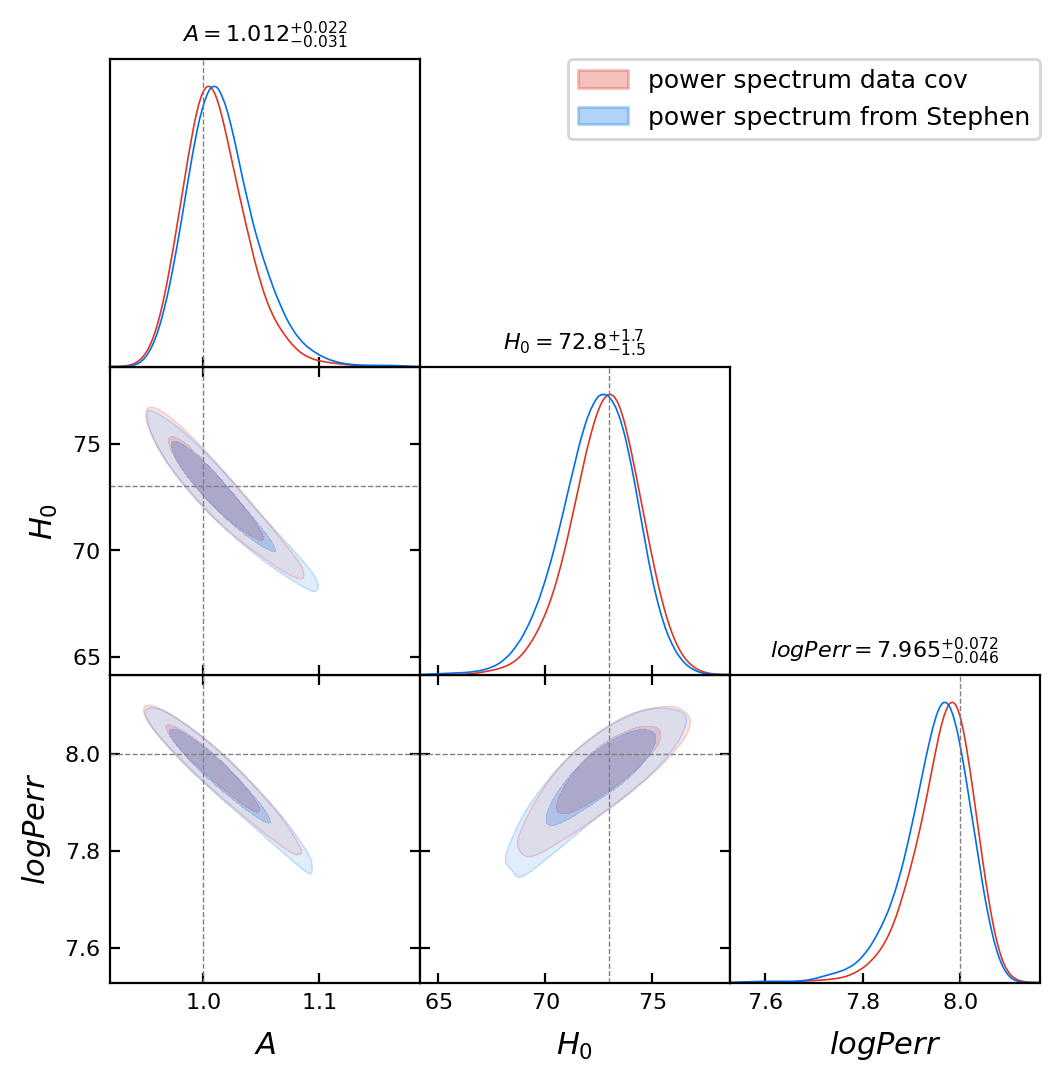

In [66]:
%matplotlib inline
plt.figure(figsize=(20,20))

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'log_Perr']
params_contour = ['A', 'H0', 'log_Perr']

markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([samples[f'pow_simple'],
                 #samples[f'pow_L0'],
                 #samples[f'pow_data_cov'],
                 #samples[f'stephen_pow_{name_base}'],
                 #samples[f'pow_analytic_cov'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')
plt.show()

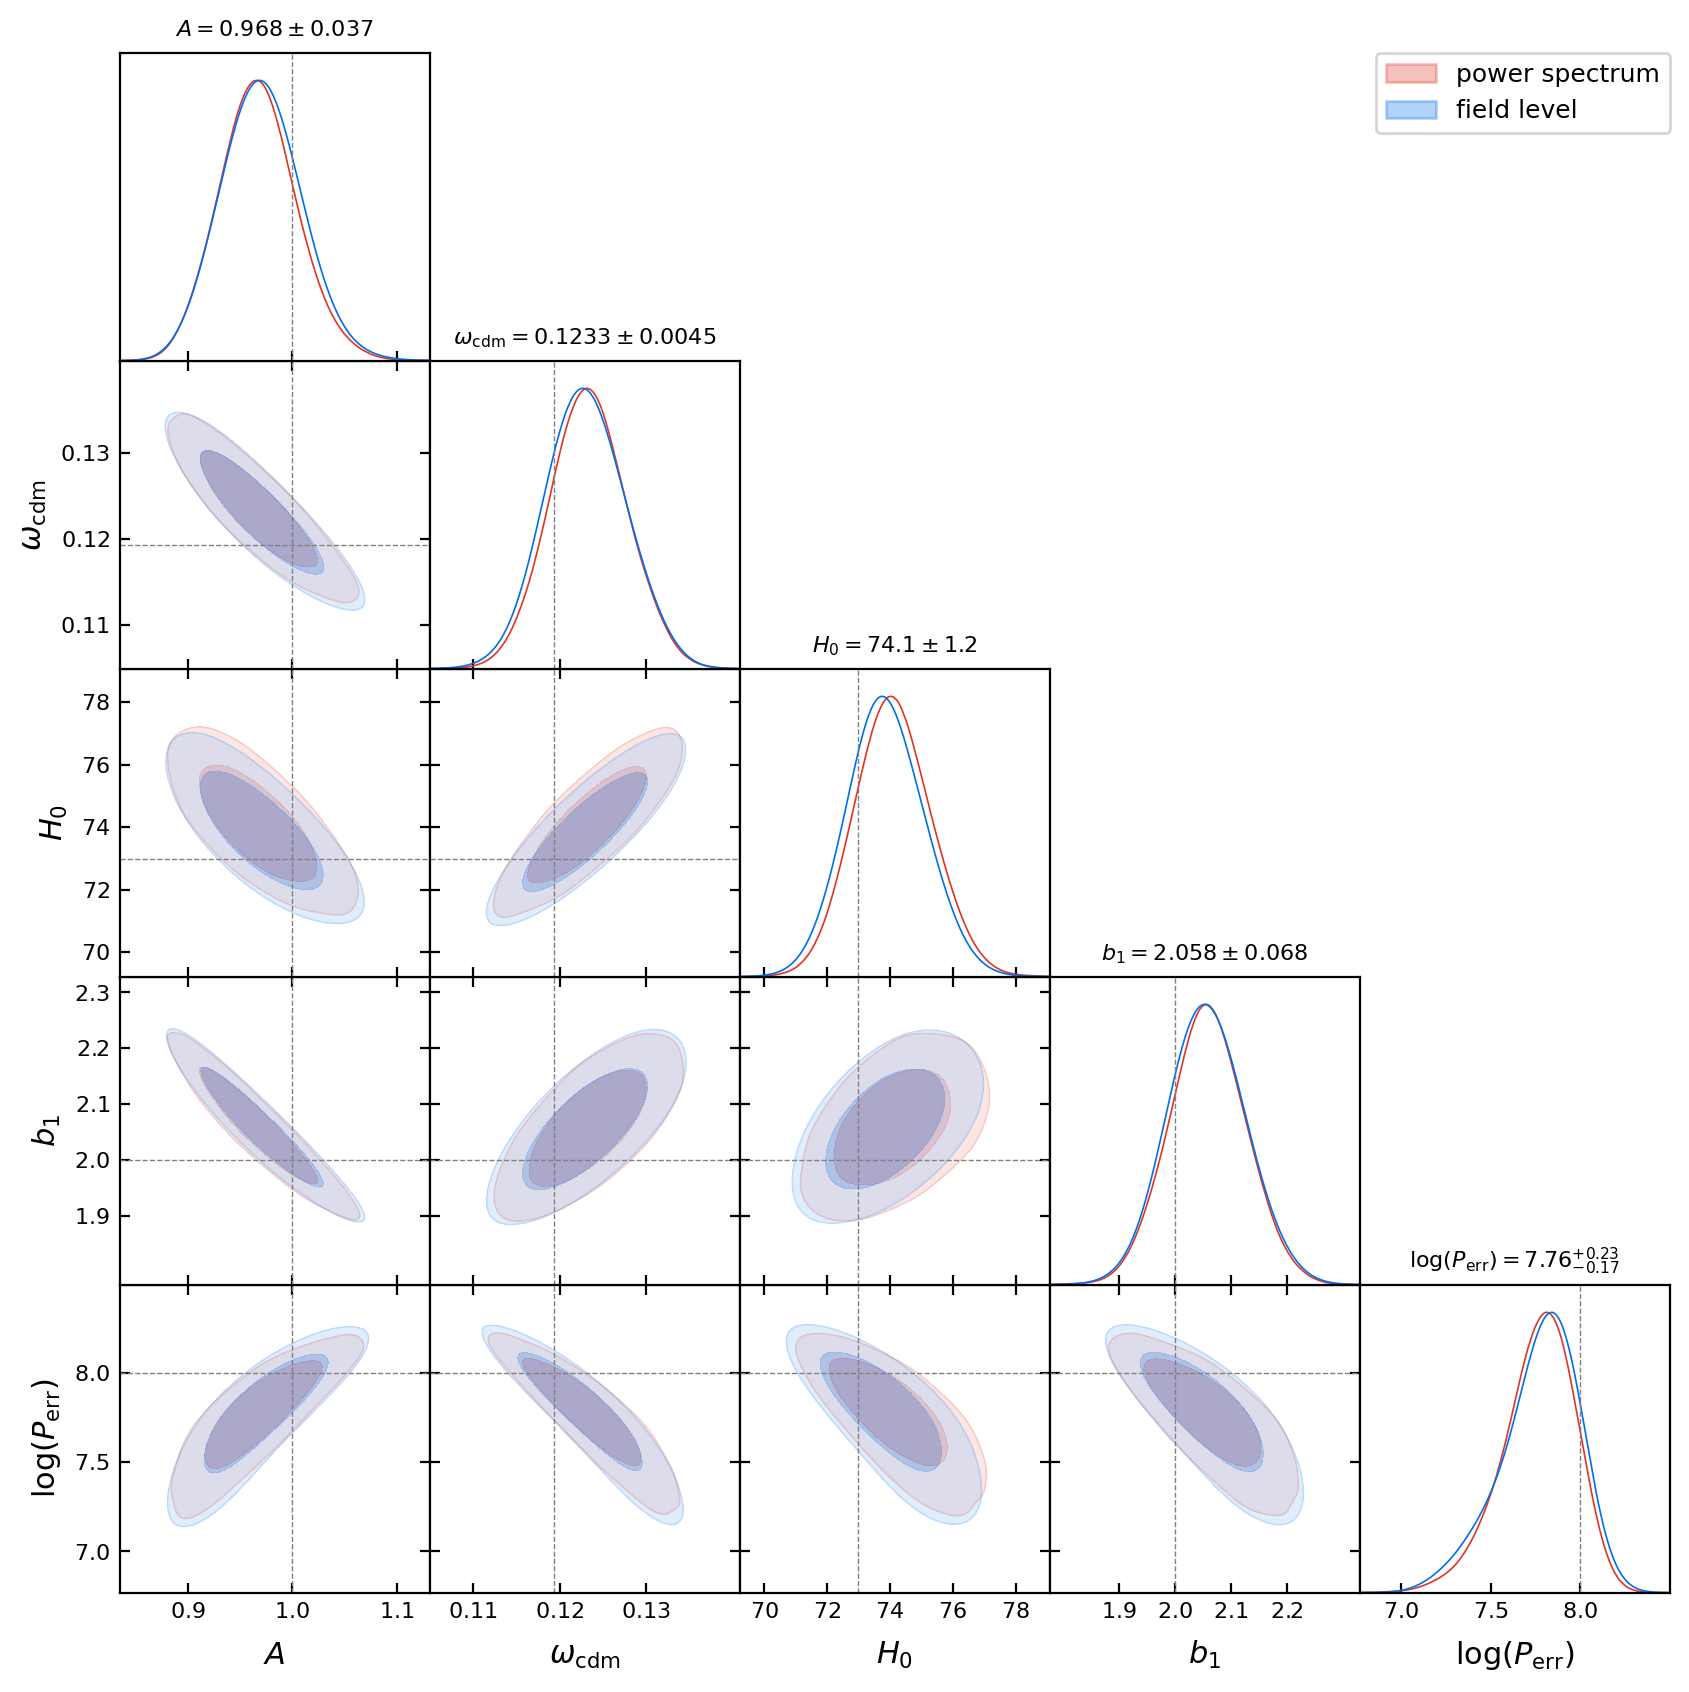

In [31]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'b1', 'log_Perr']
#params_contour = ['A', 'H0', 'log_Perr']
params_contour = ['A', 'oc', 'H0', 'b1', 'log_Perr']

markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'b1':2.0, 'log_Perr':8.0}
    
g.triangle_plot([#samples[f'pow_grid_cov_L4'],
                 #samples[f'pow_weighted_grid_cov_L4'],
                 samples[f'pow_weighted_grid_cov_sspace_L4_0.12_double'],
                 samples[f'{name_base}'],
                 #samples[f'stephen_pow_{name_base}'],
                 #samples[f'pow_analytic_cov'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')
#plt.show()
plt.savefig(f'/home/kakitsu/field_level/field_level/figs/gauss_rsd_{kmax}.pdf', transparent=True)


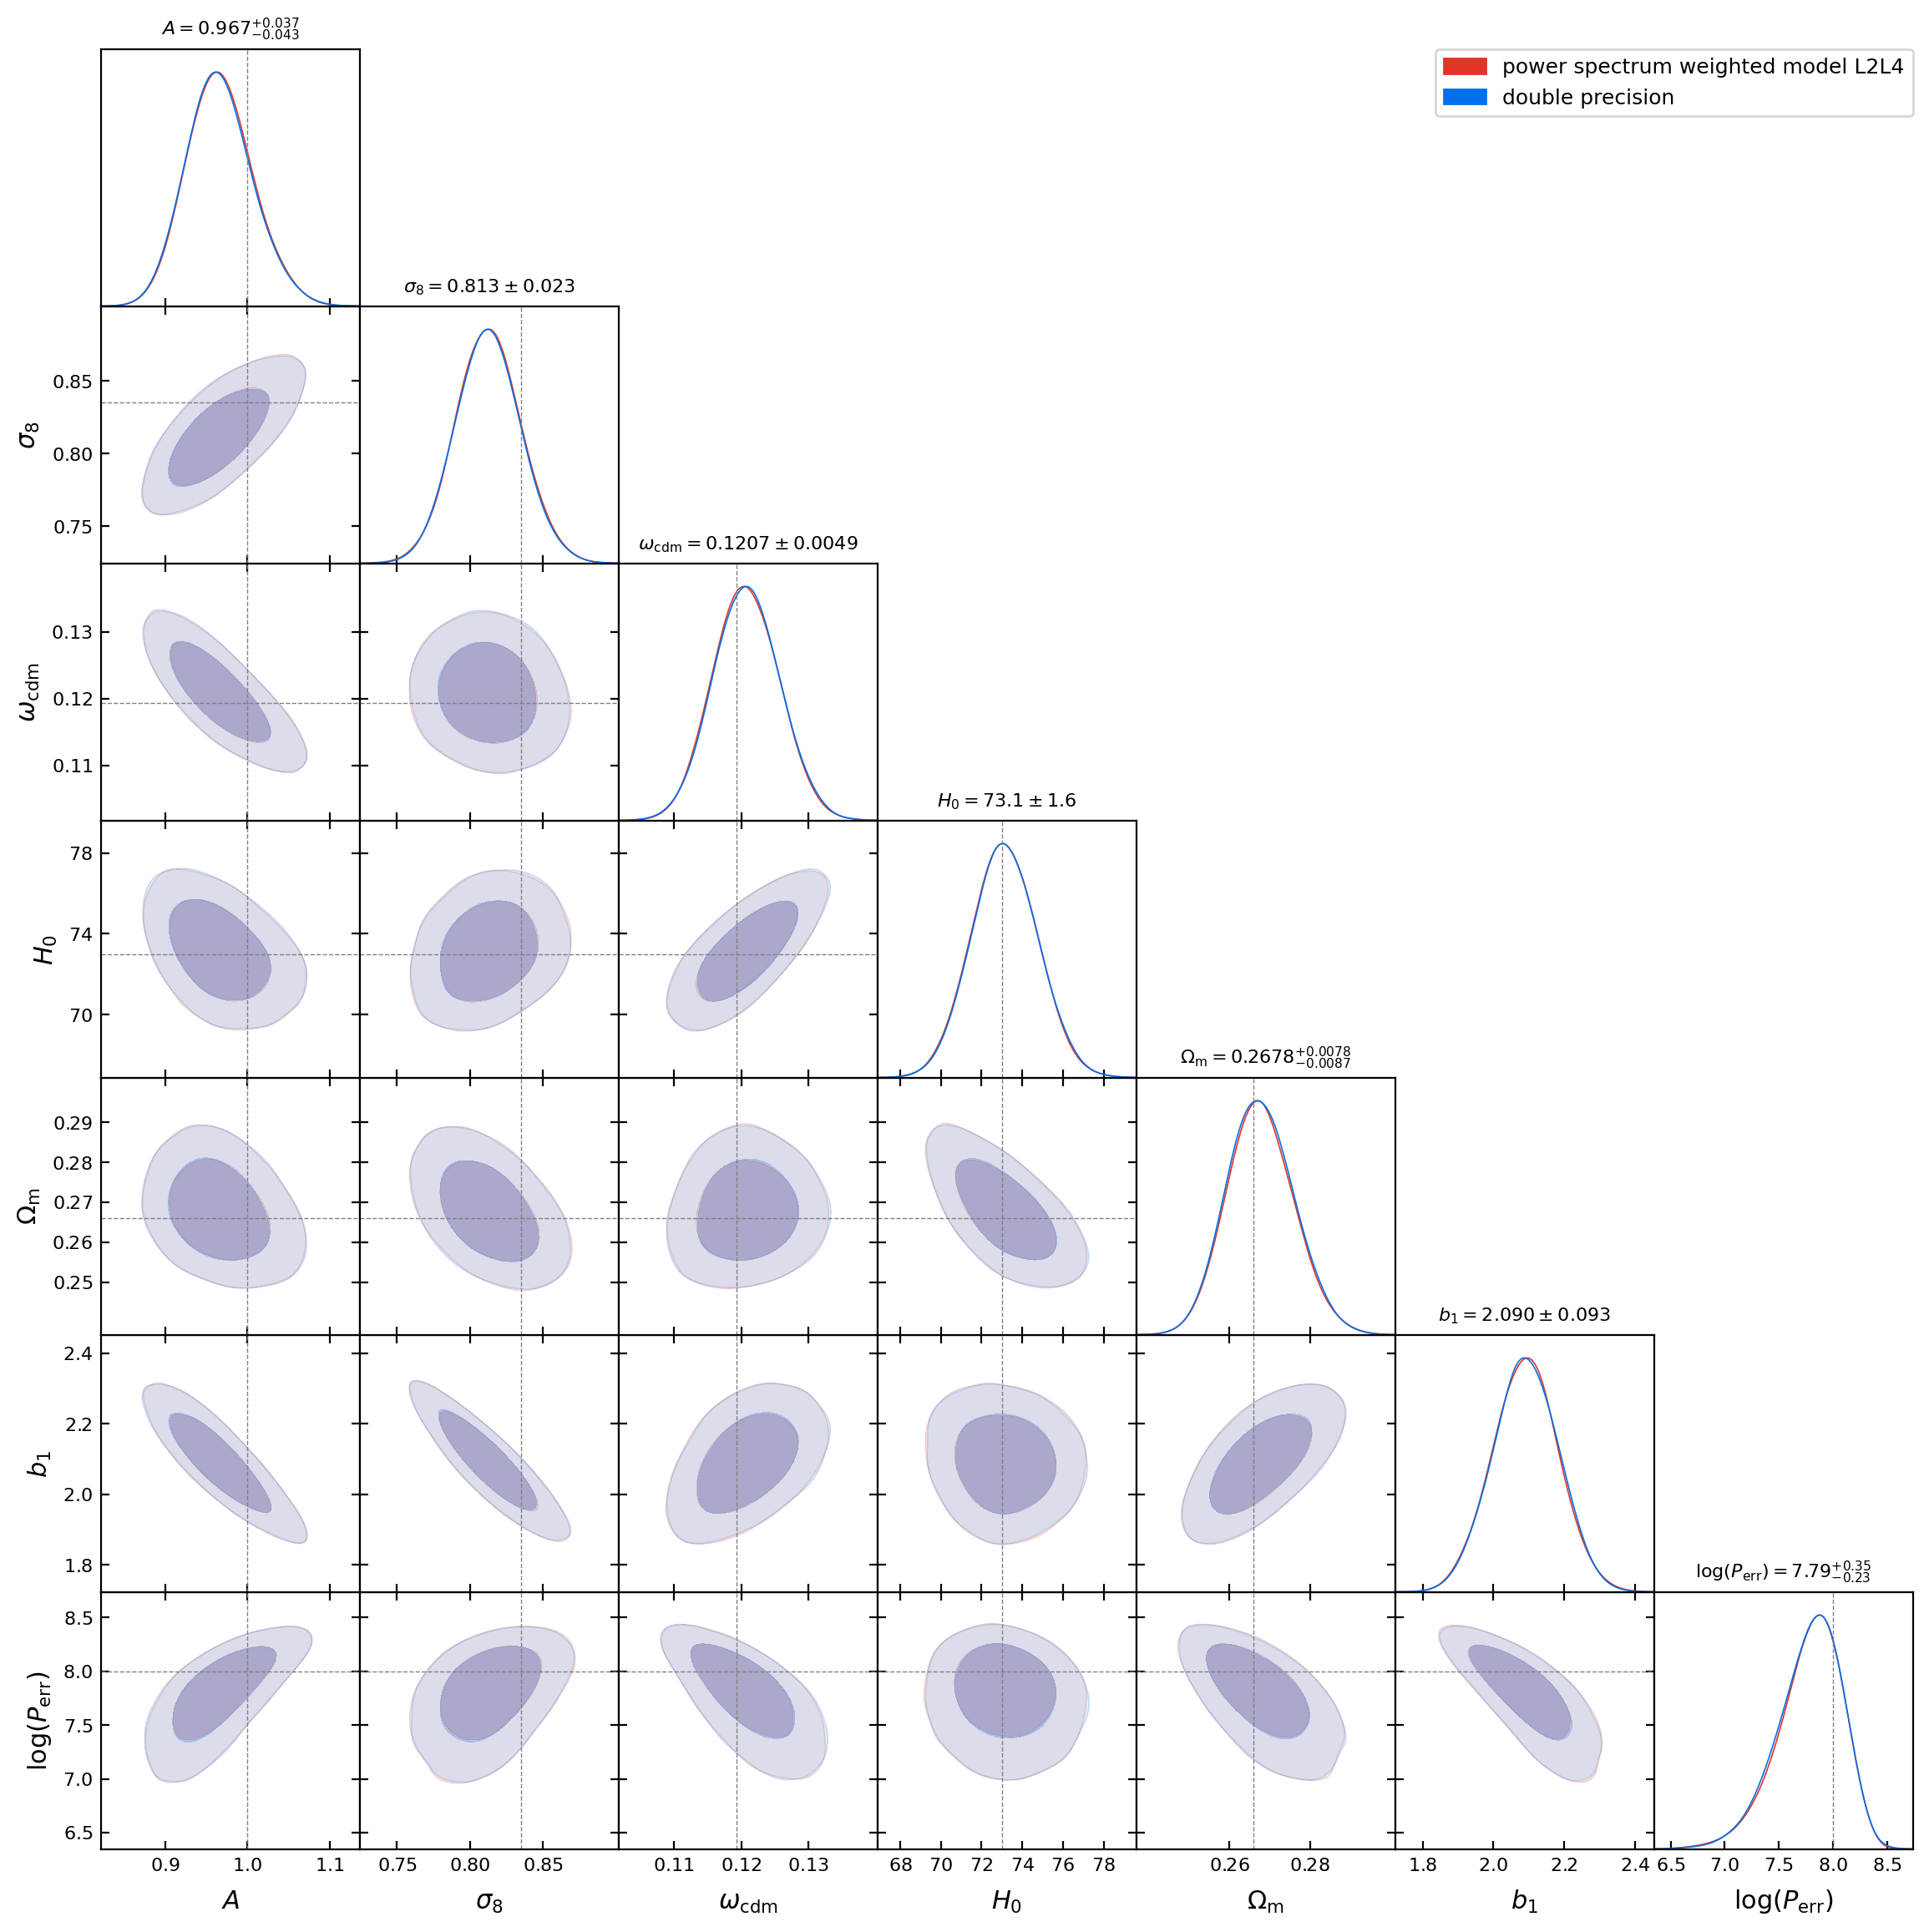

In [27]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'b1', 'log_Perr']
#params_contour = ['A', 'H0', 'log_Perr']

markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([#samples[f'pow_grid_cov_L4'],
                 samples[f'pow_weighted_grid_cov_L4'],
                 samples[f'pow_weighted_grid_cov_sspace_L4_0.1_double'],
                 #samples[f'{name_base}'],
                 #samples[f'stephen_pow_{name_base}'],
                 #samples[f'pow_analytic_cov'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')
plt.show()

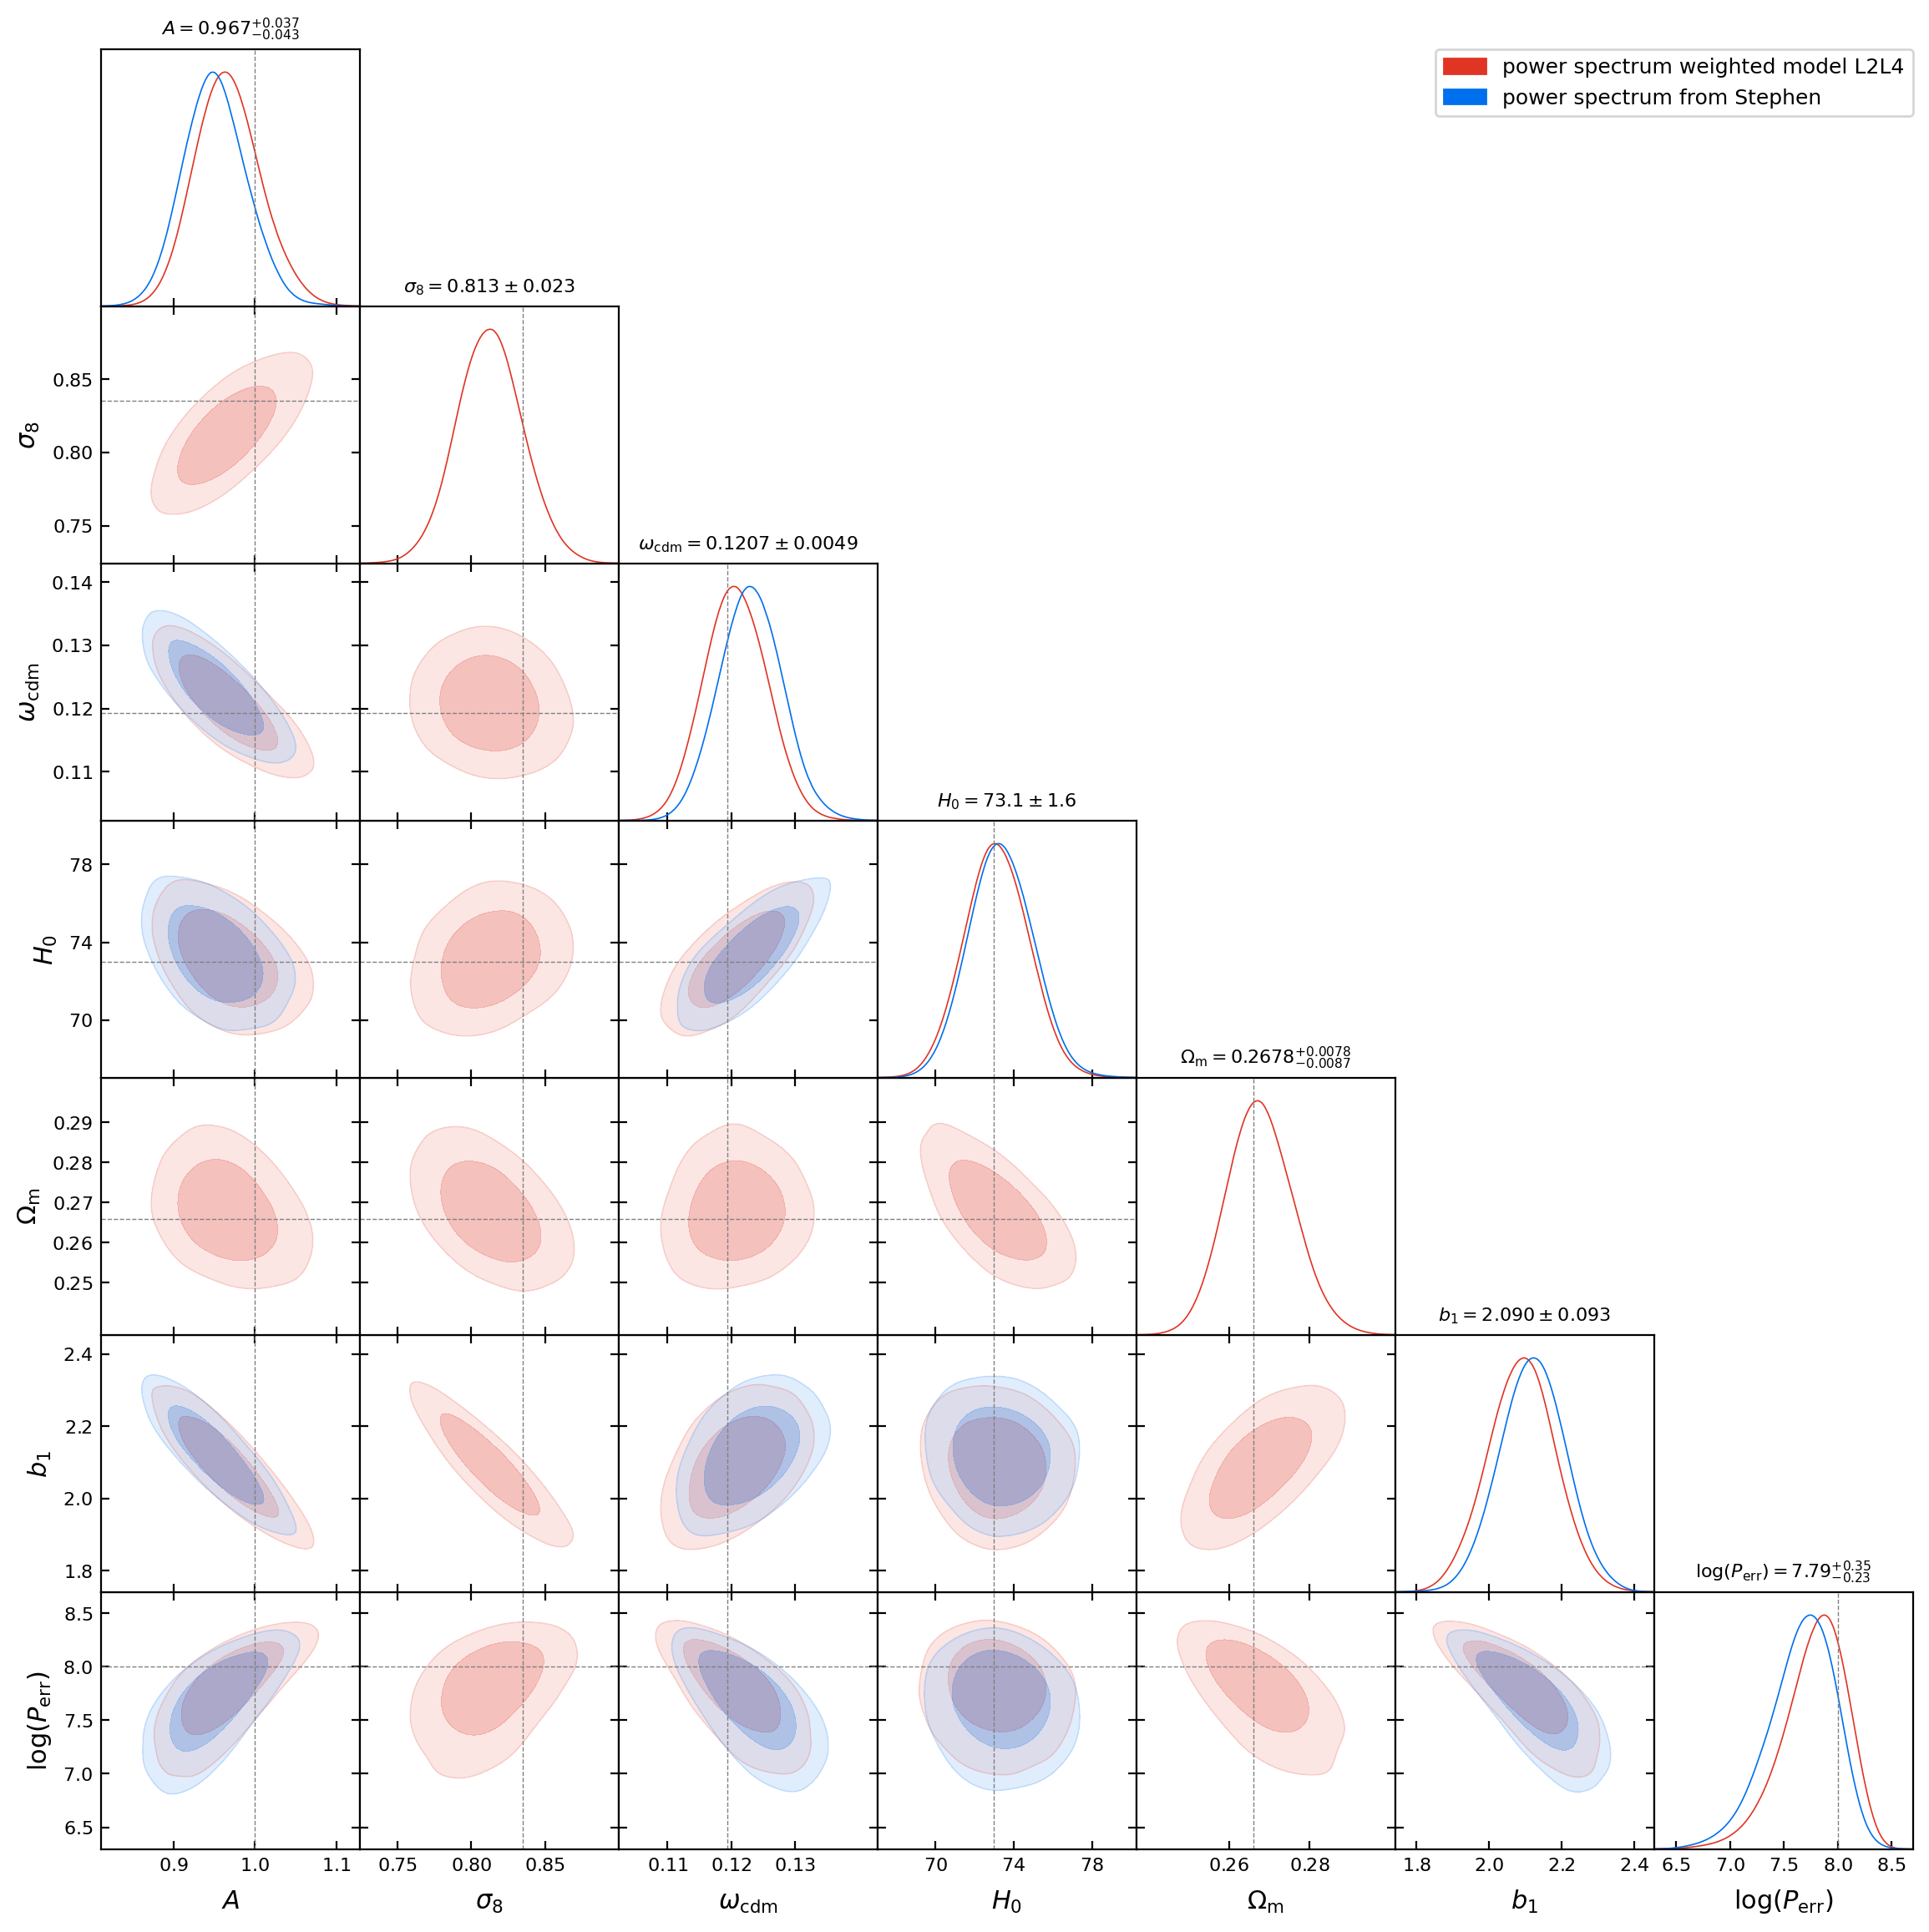

In [61]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'b1', 'log_Perr']
#params_contour = ['A', 'H0', 'log_Perr']

markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([#samples[f'pow_grid_cov_L4'],
                 samples[f'pow_weighted_grid_cov_L4'],
                 #samples[f'{name_base}'],
                 #samples[f'stephen_pow_{name_base}'],
                 #samples[f'pow_analytic_cov'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')
plt.show()

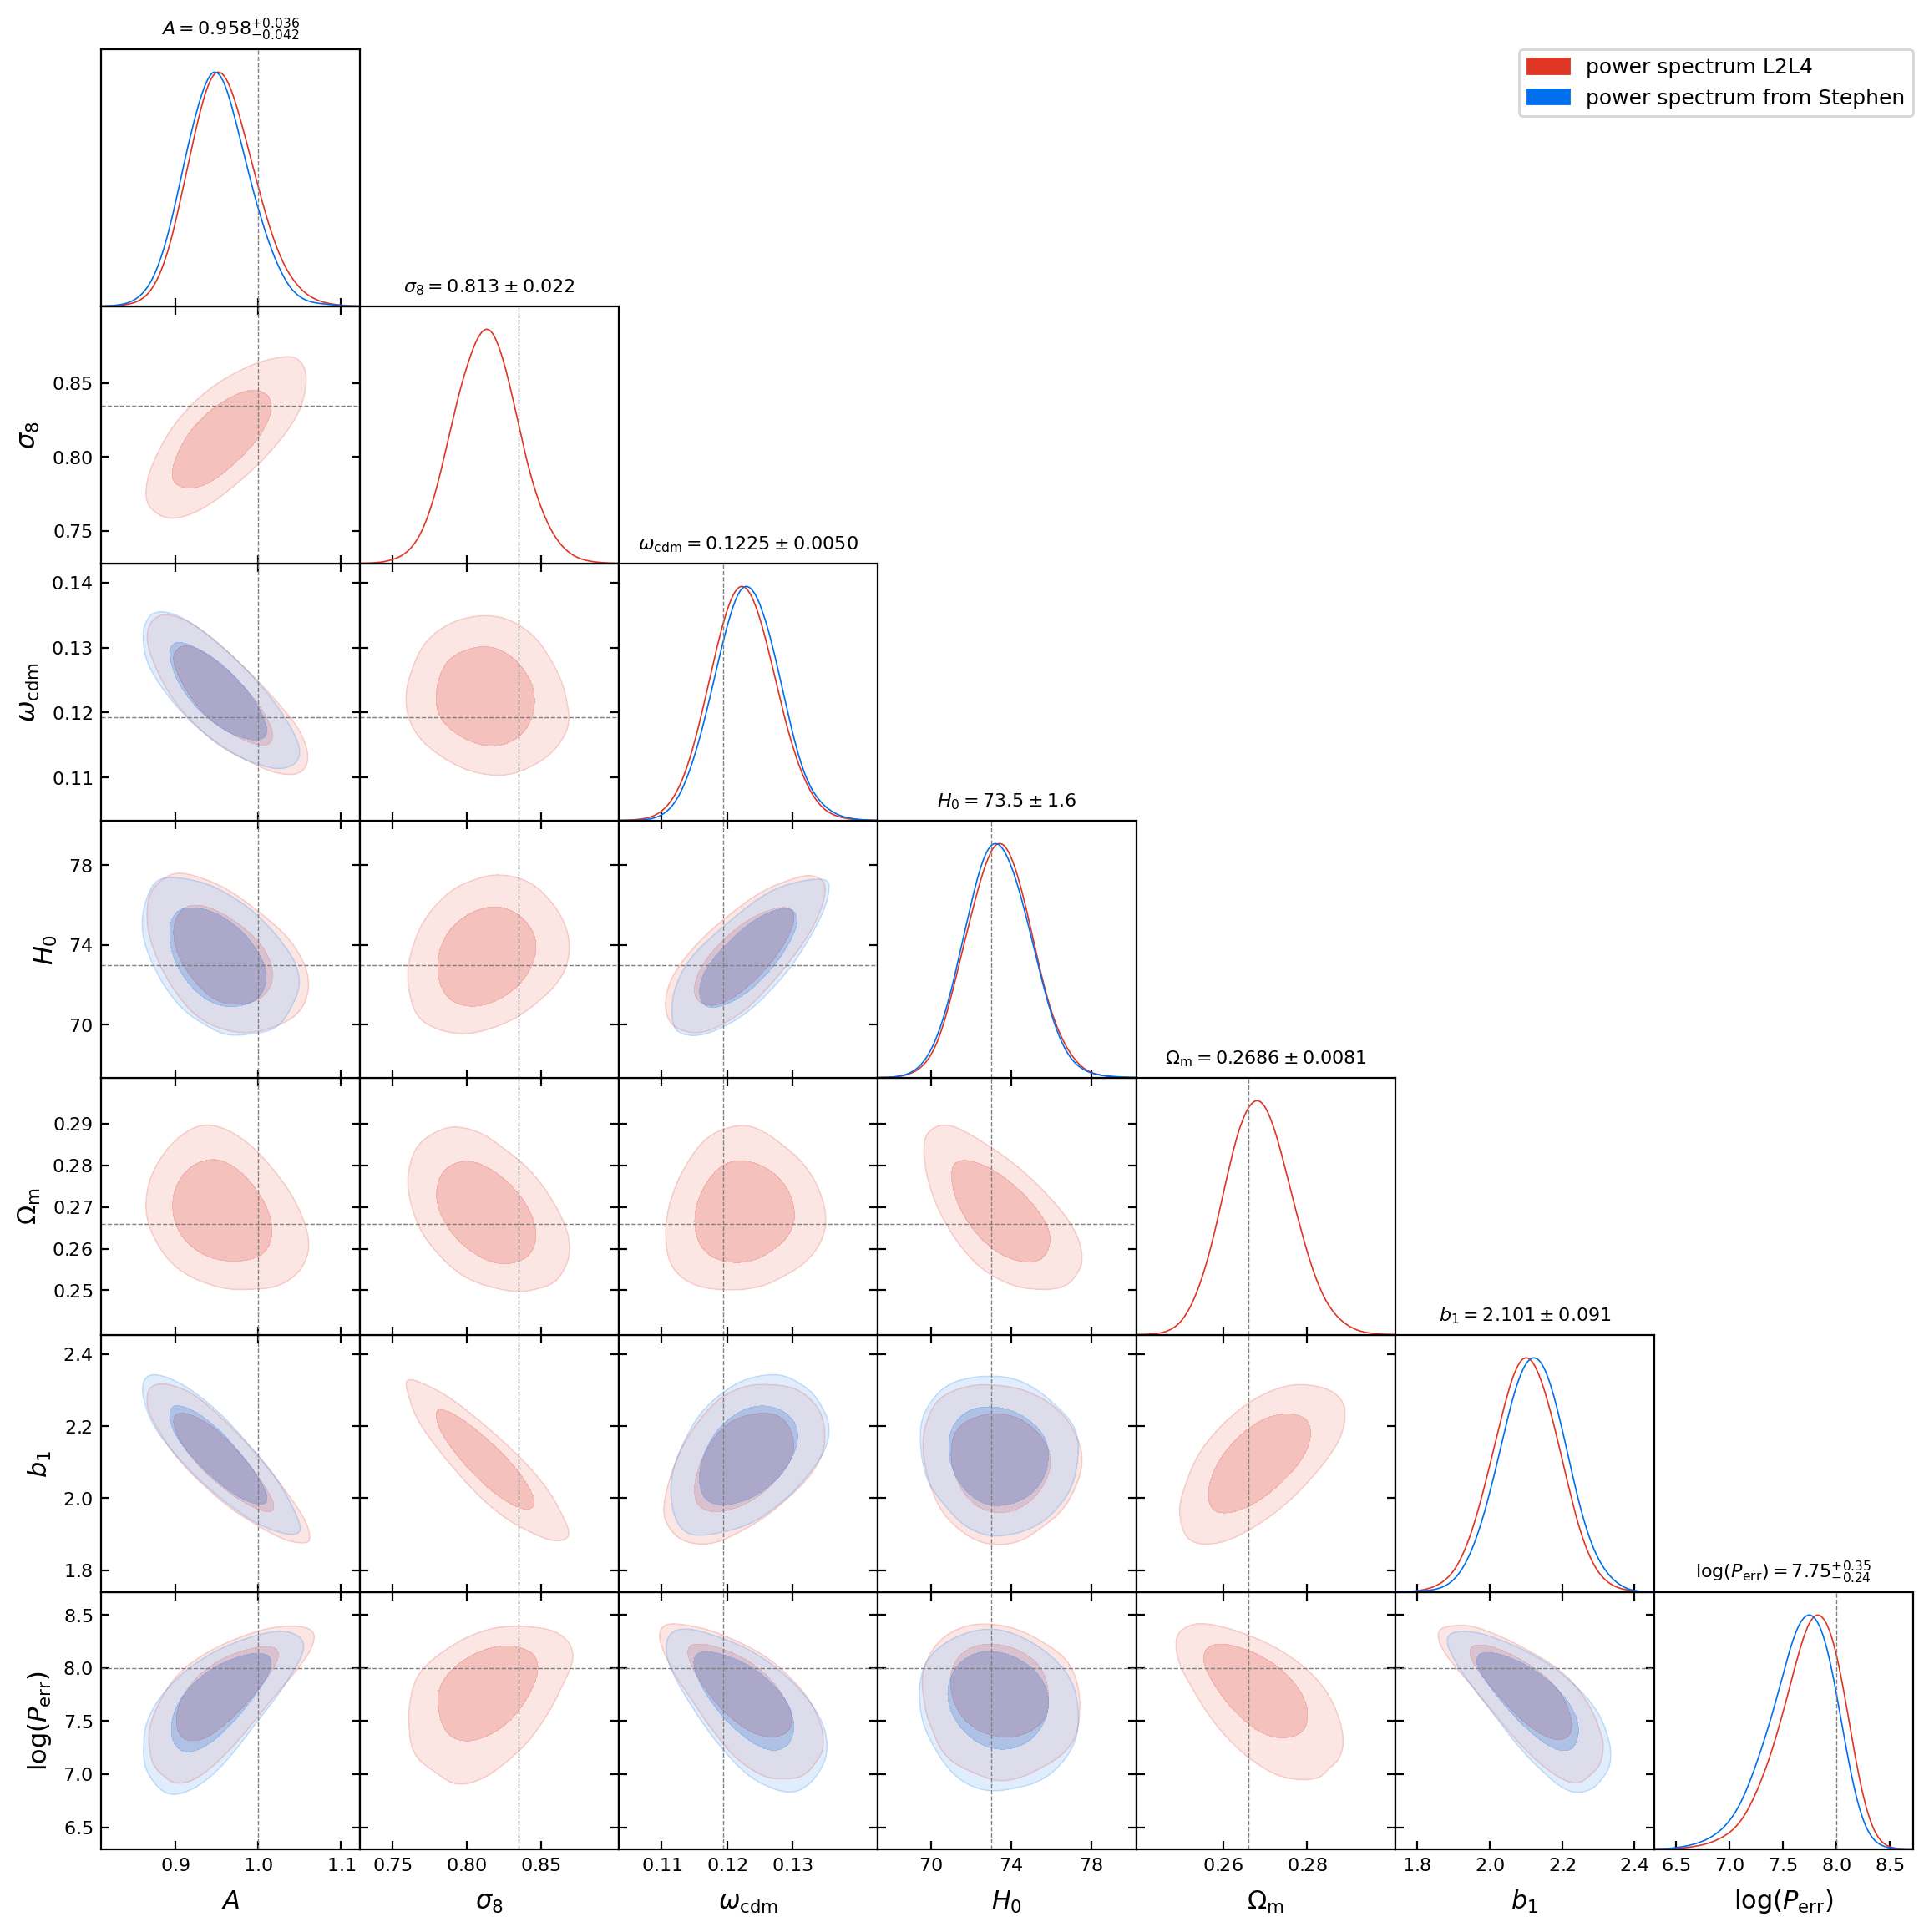

In [62]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'b1', 'log_Perr']
#params_contour = ['A', 'H0', 'log_Perr']

markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([#samples[f'pow_grid_cov_L4'],
                 samples[f'pow_grid_cov_L4'],
                 #samples[f'{name_base}'],
                 samples[f'stephen_pow_{name_base}'],
                 #samples[f'pow_analytic_cov'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')
plt.show()

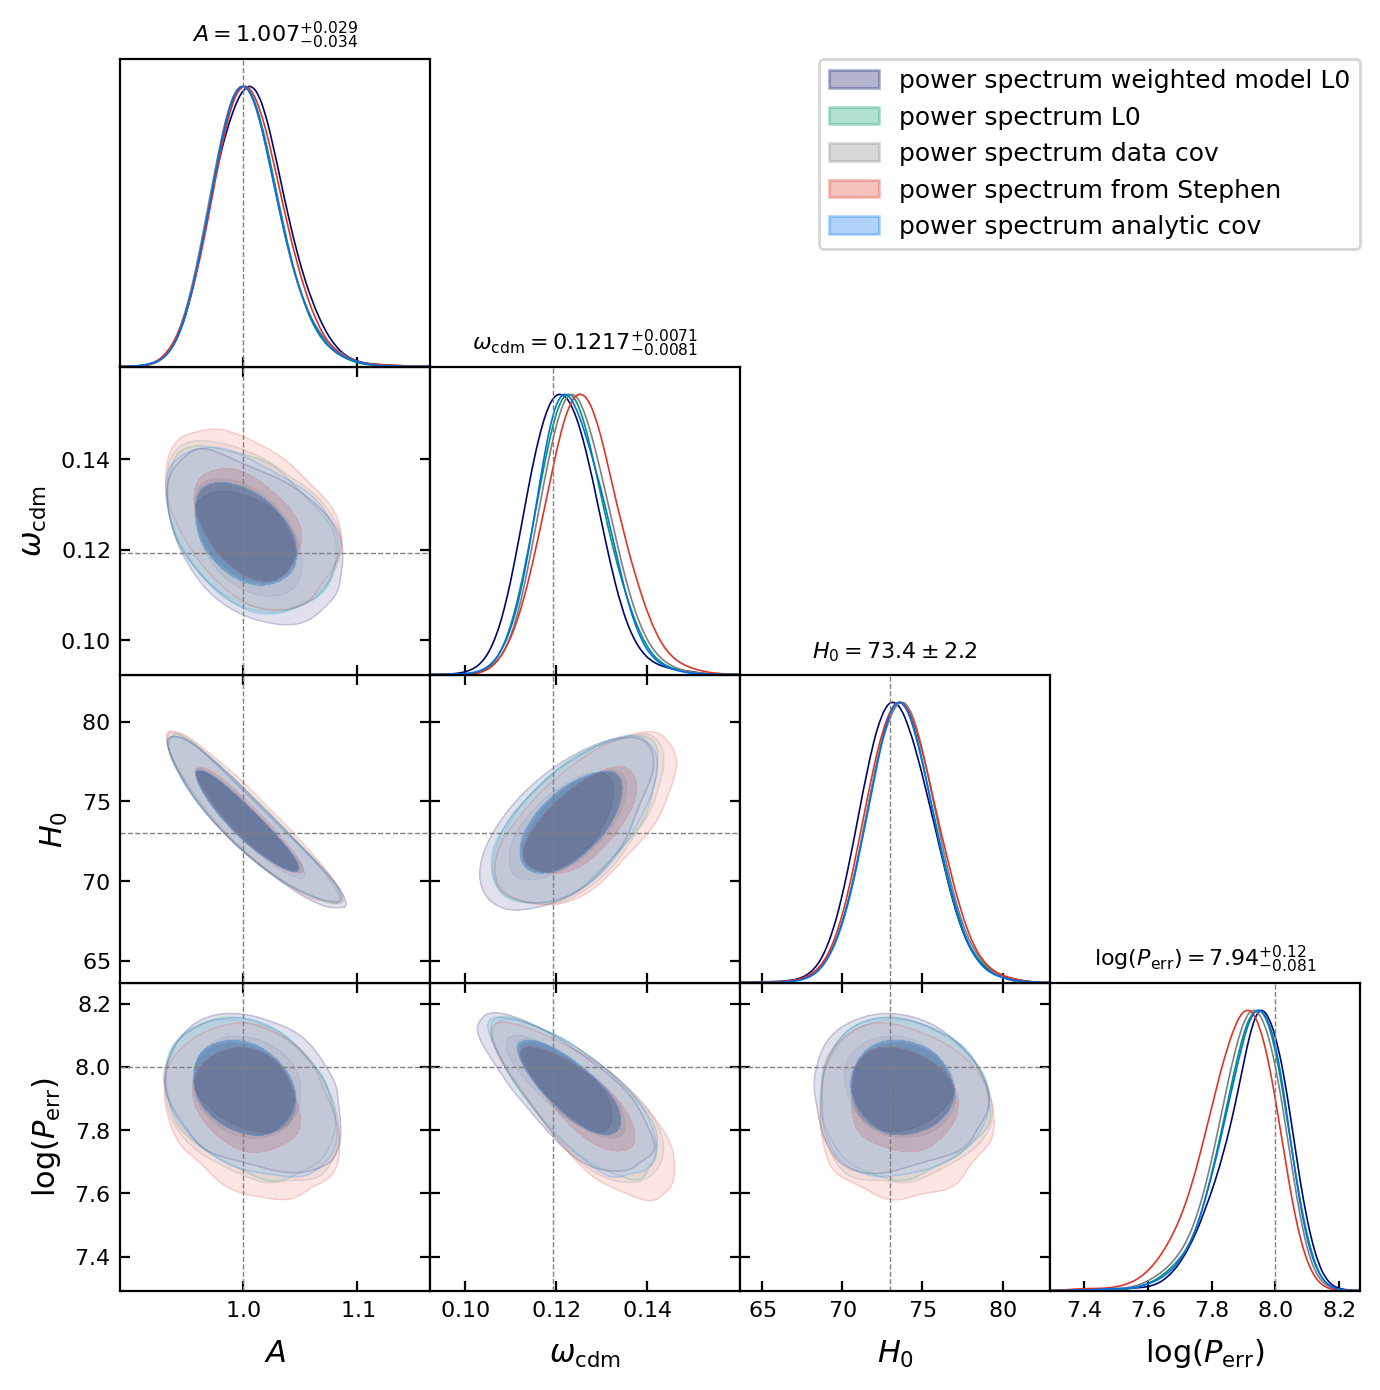

In [27]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'log_Perr']
params_contour = ['A', 'oc', 'H0', 'log_Perr']

markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([samples[f'pow_weighted_L0'],
                 samples[f'pow_L0'],
                 samples[f'pow_data_cov'],
                 samples[f'stephen_pow_{name_base}'],
                 samples[f'pow_analytic_cov'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')

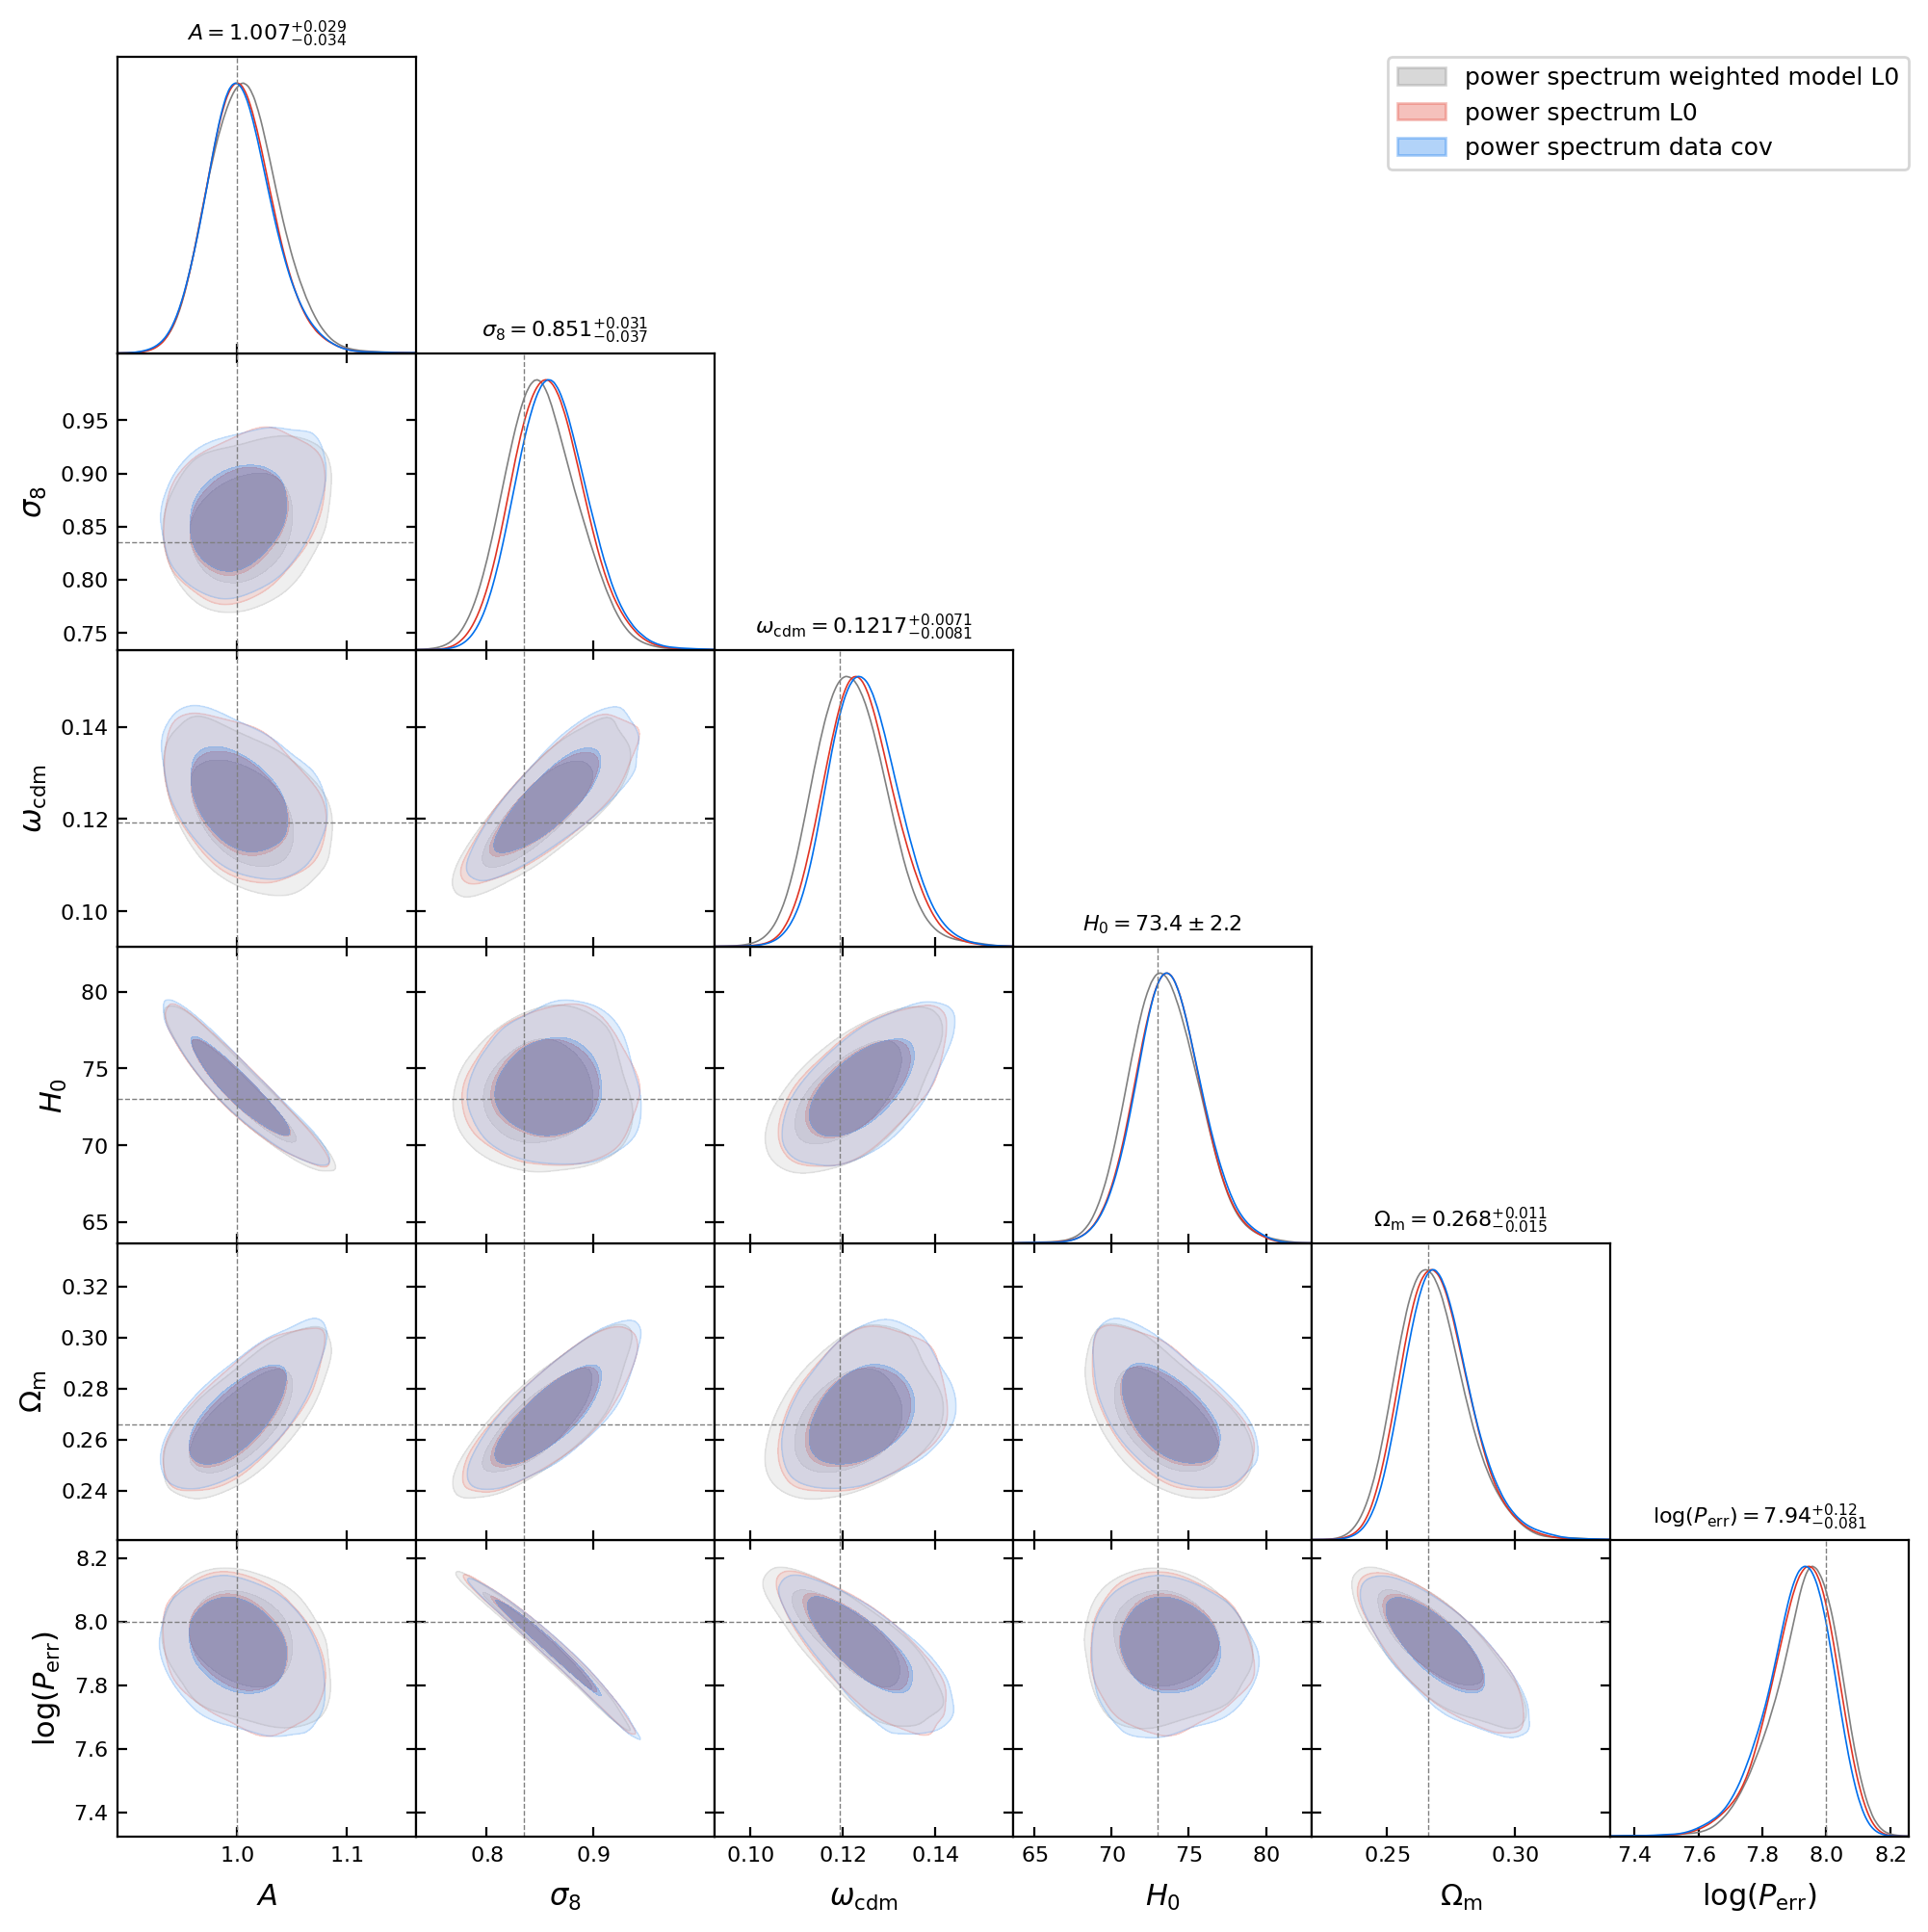

In [30]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'log_Perr']


markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([samples[f'pow_weighted_L0'],
                 samples[f'pow_L0'],
                 #samples[f'pow_analytic_cov'],
                 samples[f'pow_data_cov'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')

In [58]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'log_Perr']


markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([
                 samples[f'pow_analytic_cov'],
                 samples[f'pow_data_cov'],
                 samples[f'stephen_pow_{name_base}'],
                 #samples[f'pow_L4'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')

KeyError: 'pow_analytic_cov'

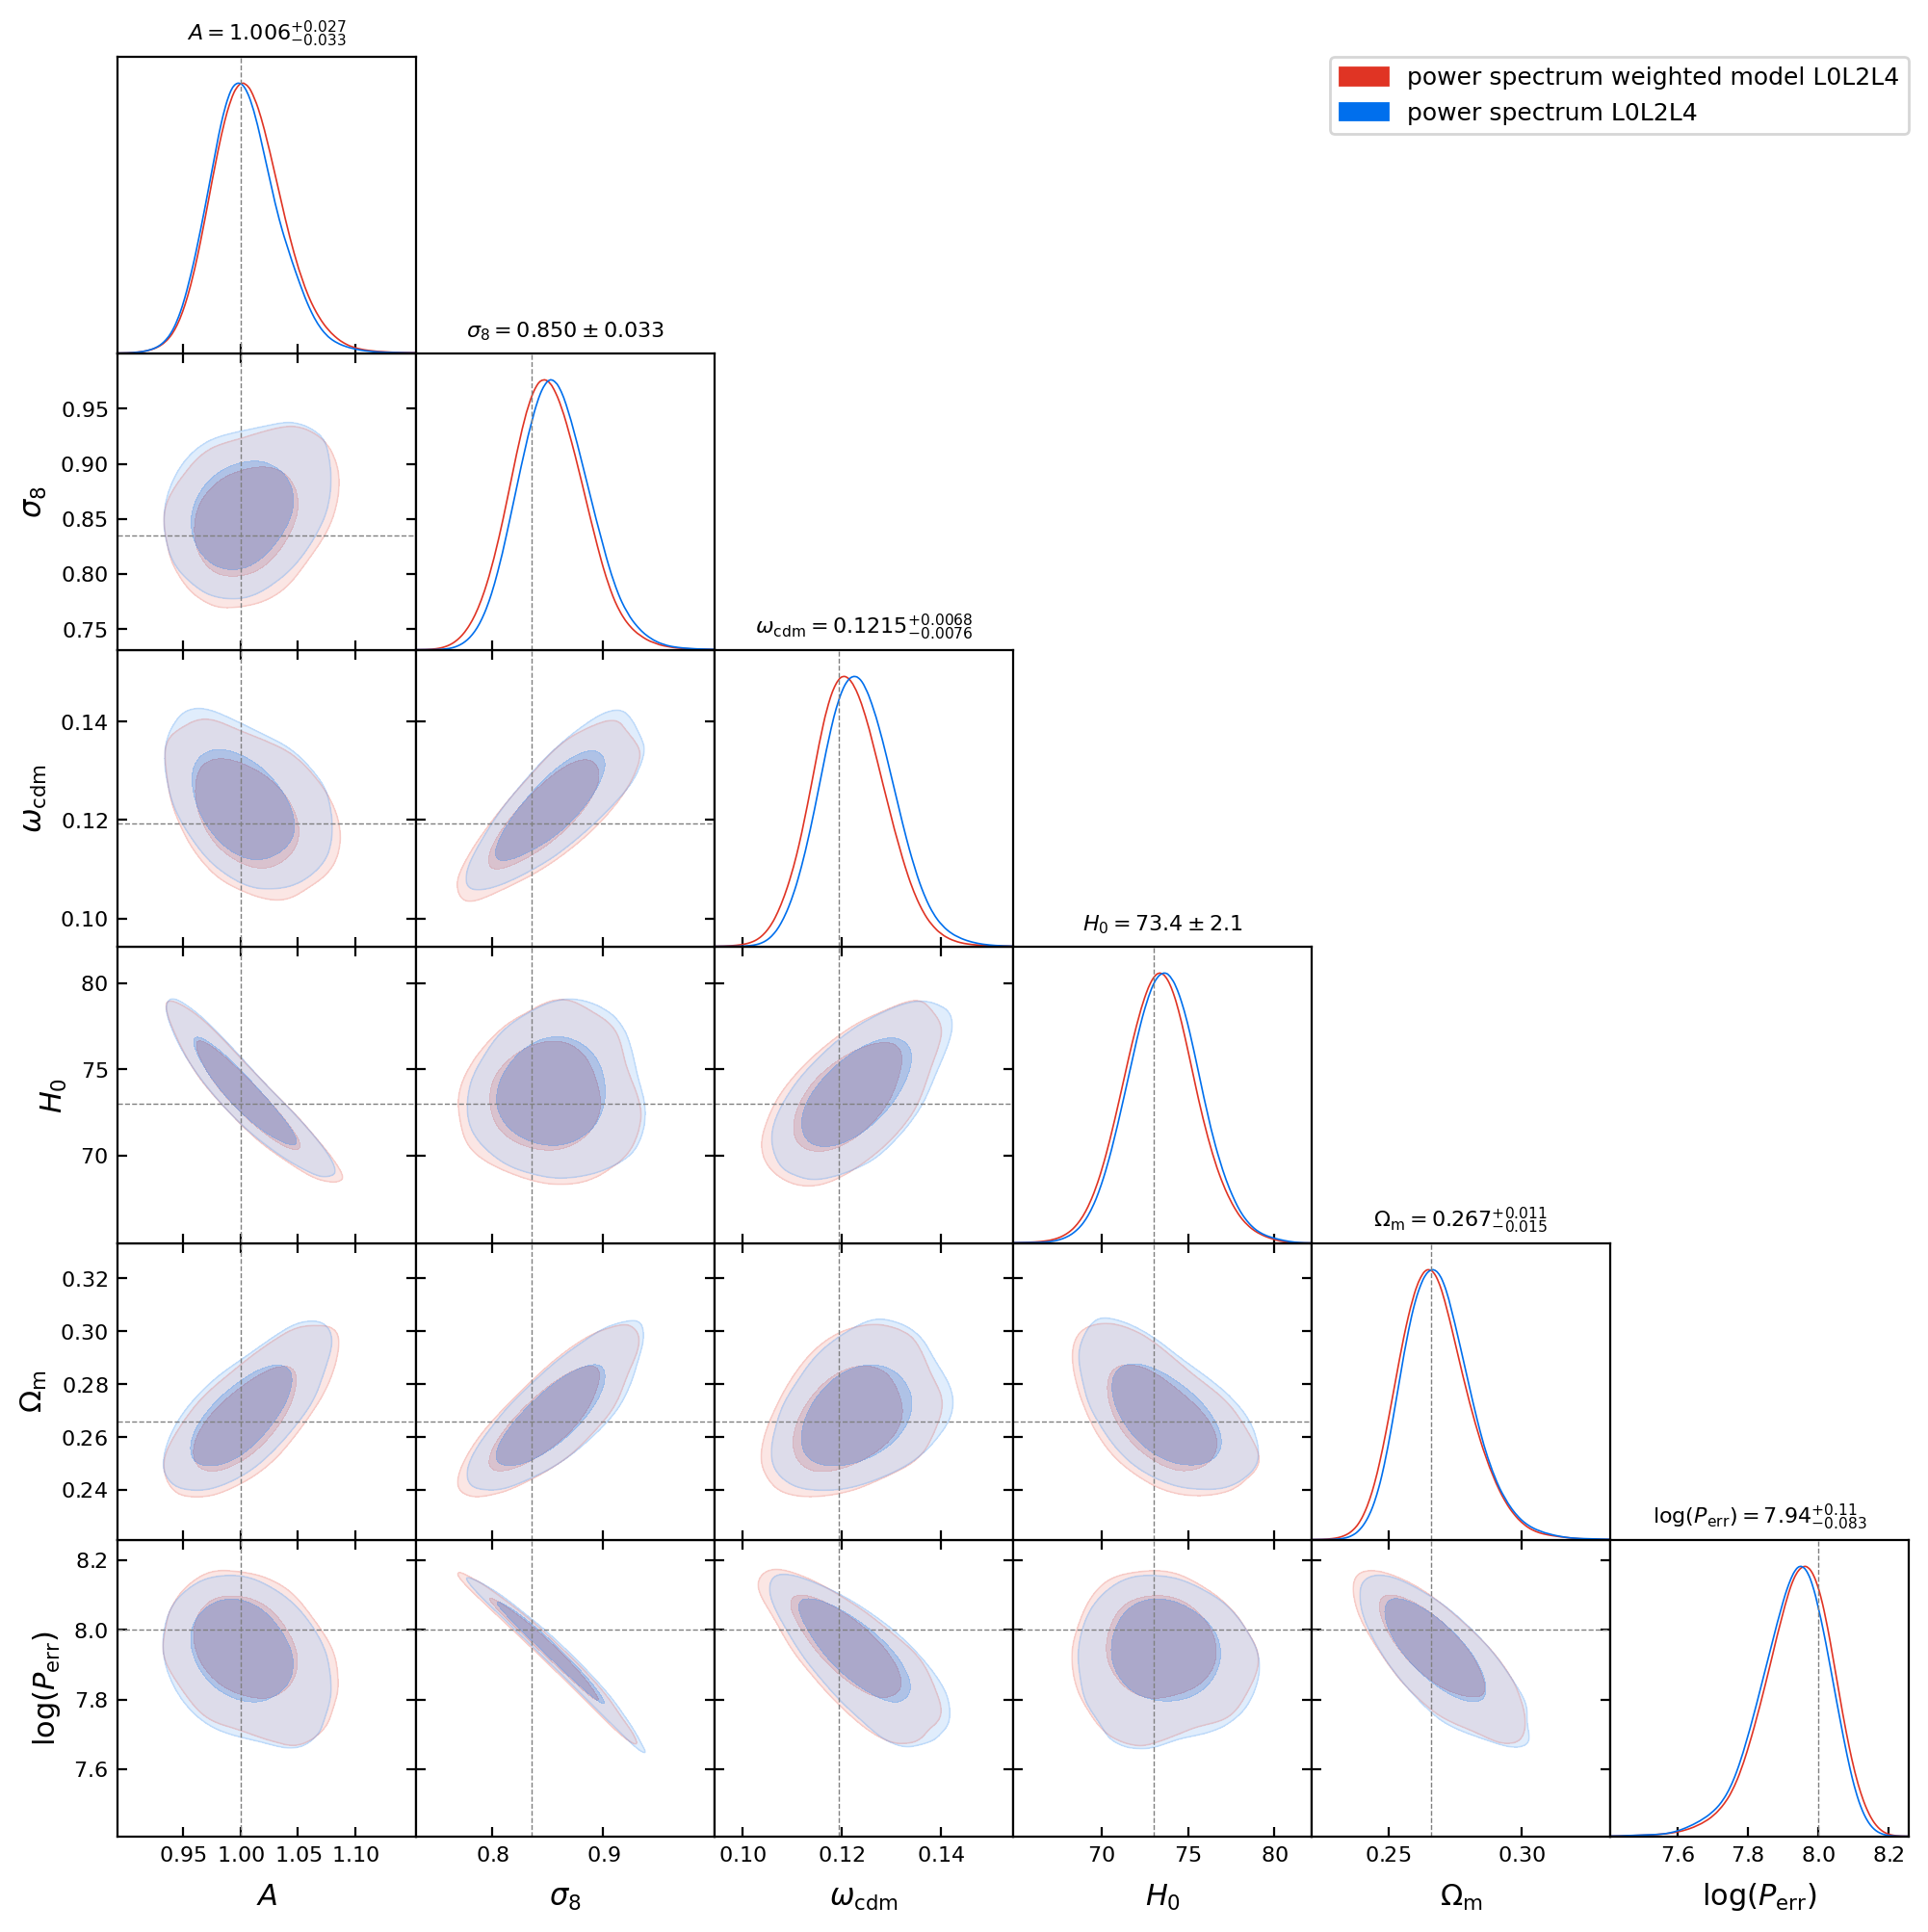

In [44]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'log_Perr']


markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([samples[f'pow_weighted_L4'],
                 samples[f'pow_L4'],
                 #samples[f'pow_L4'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')

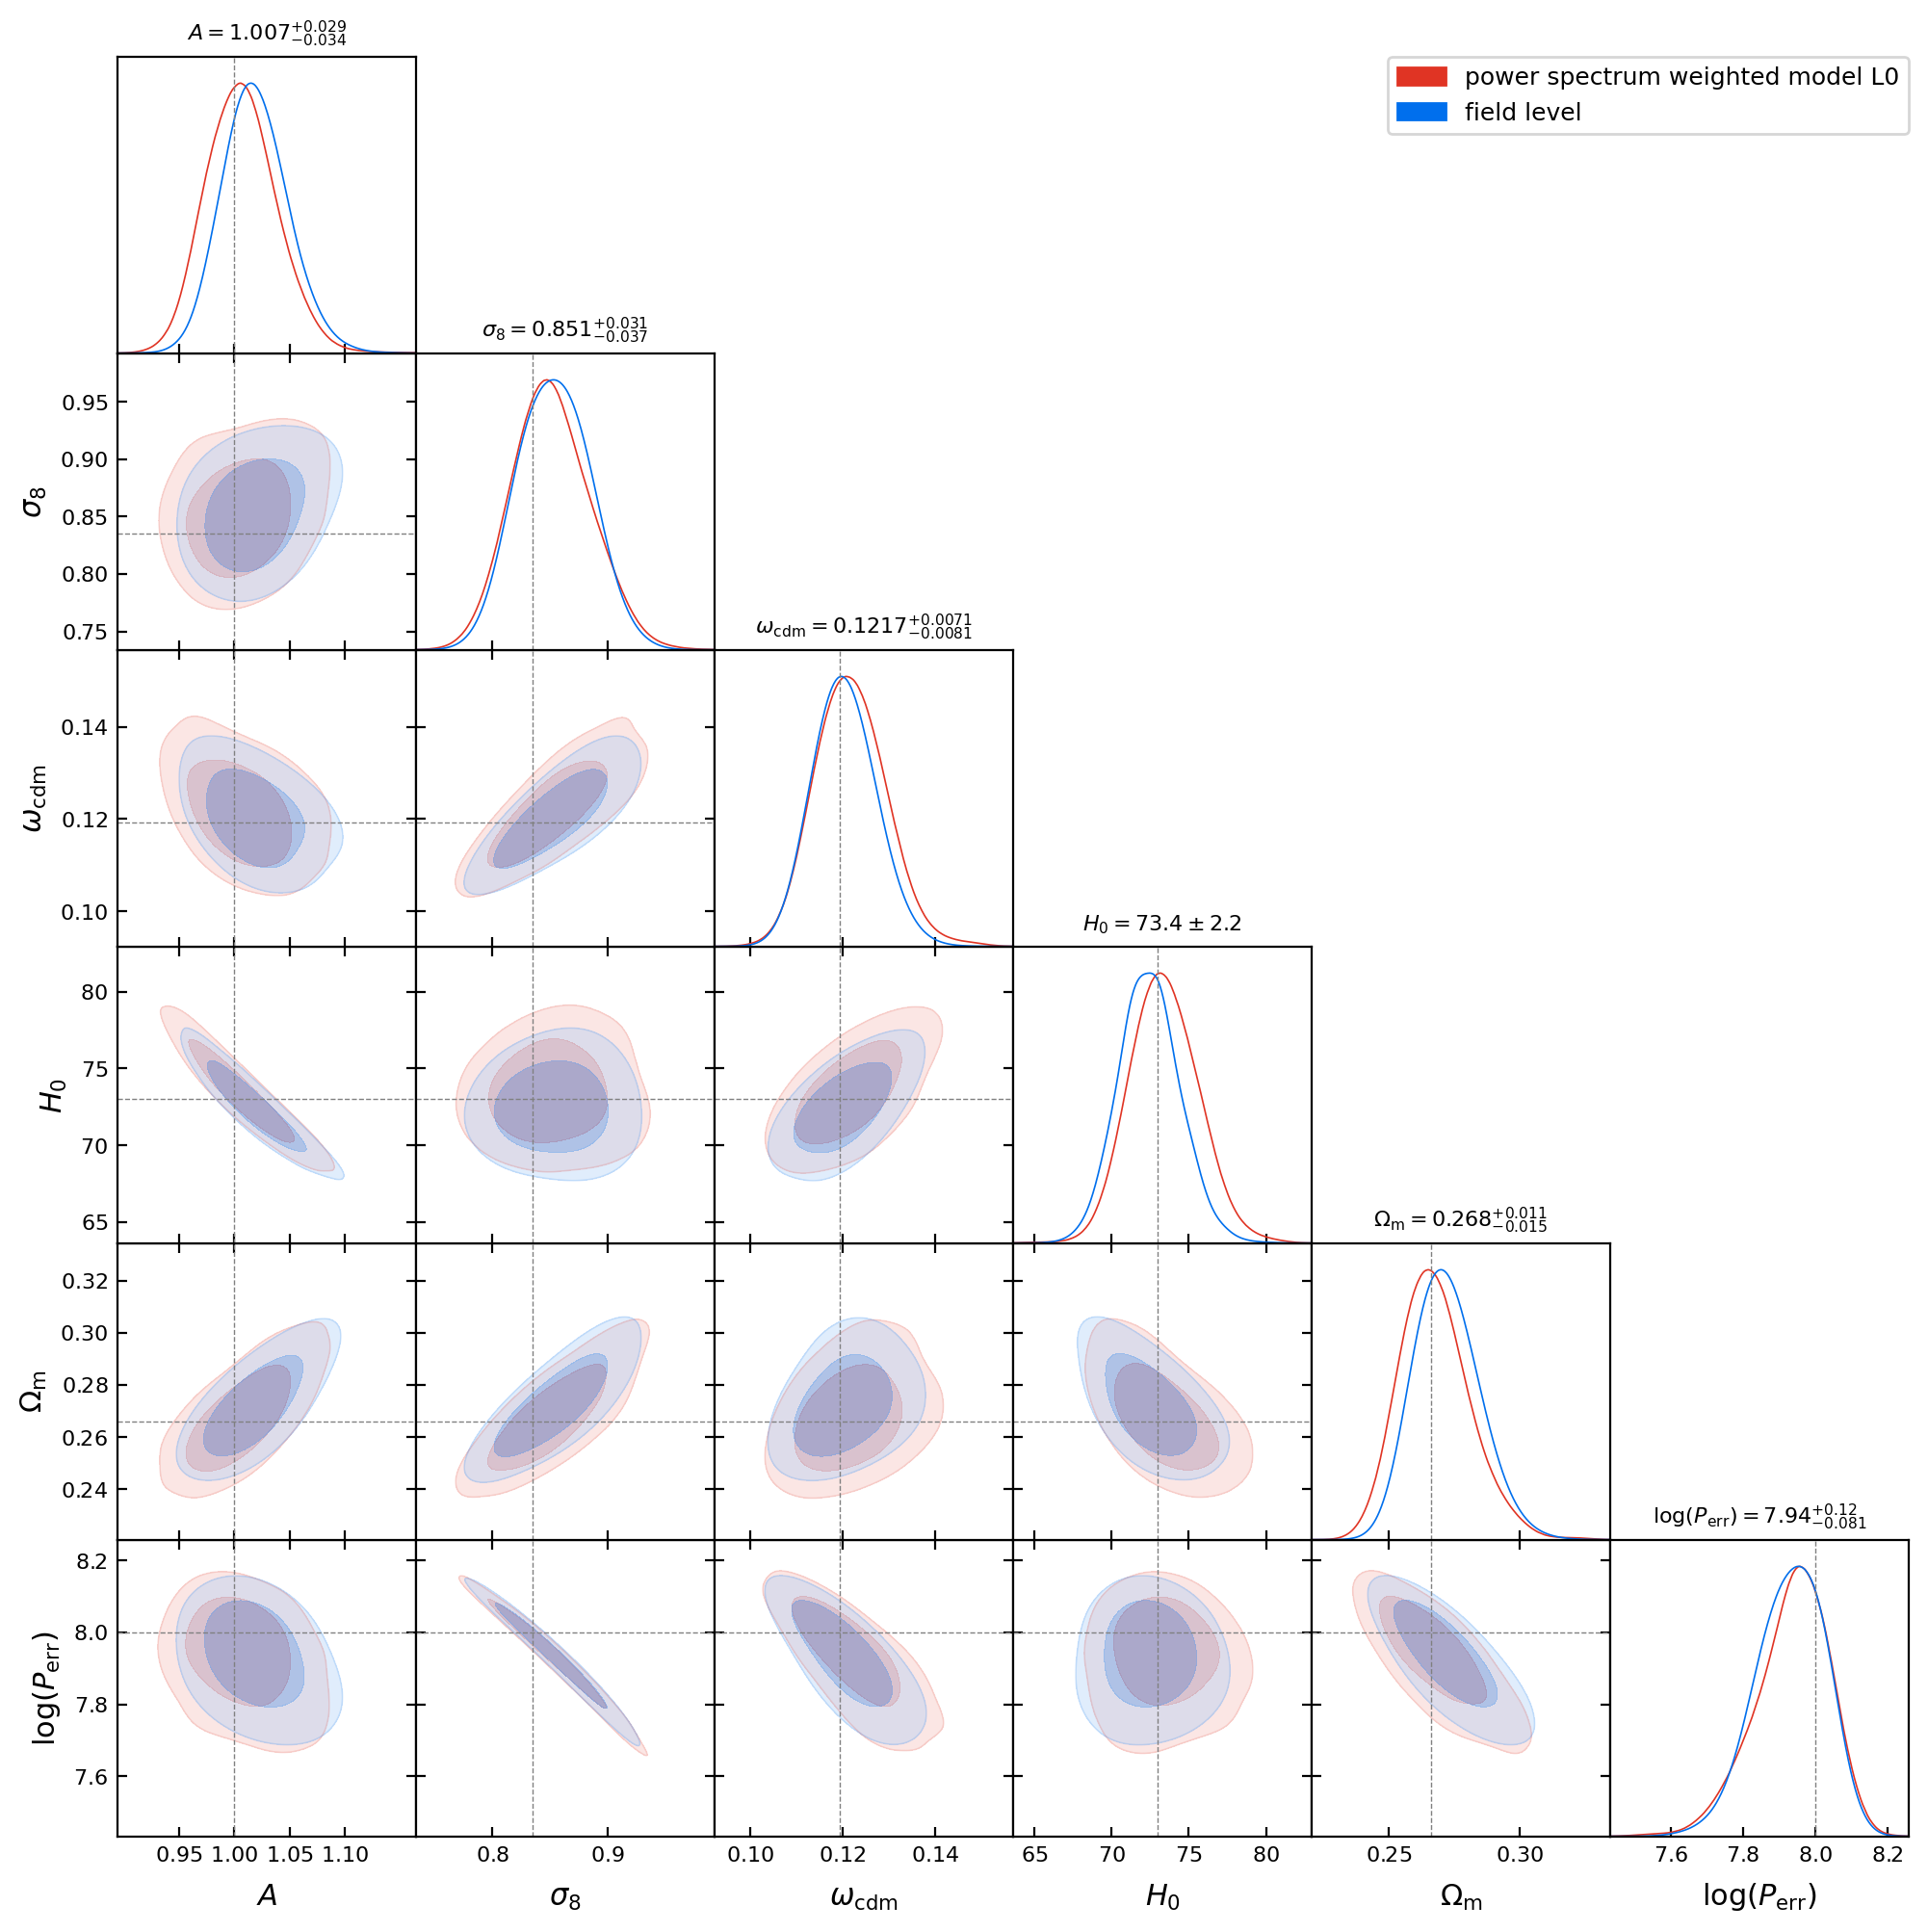

In [85]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'log_Perr']


markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([samples[f'pow_weighted_L0'],
                 samples[f'{name_base}'],
                 #samples[f'pow_L4'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')

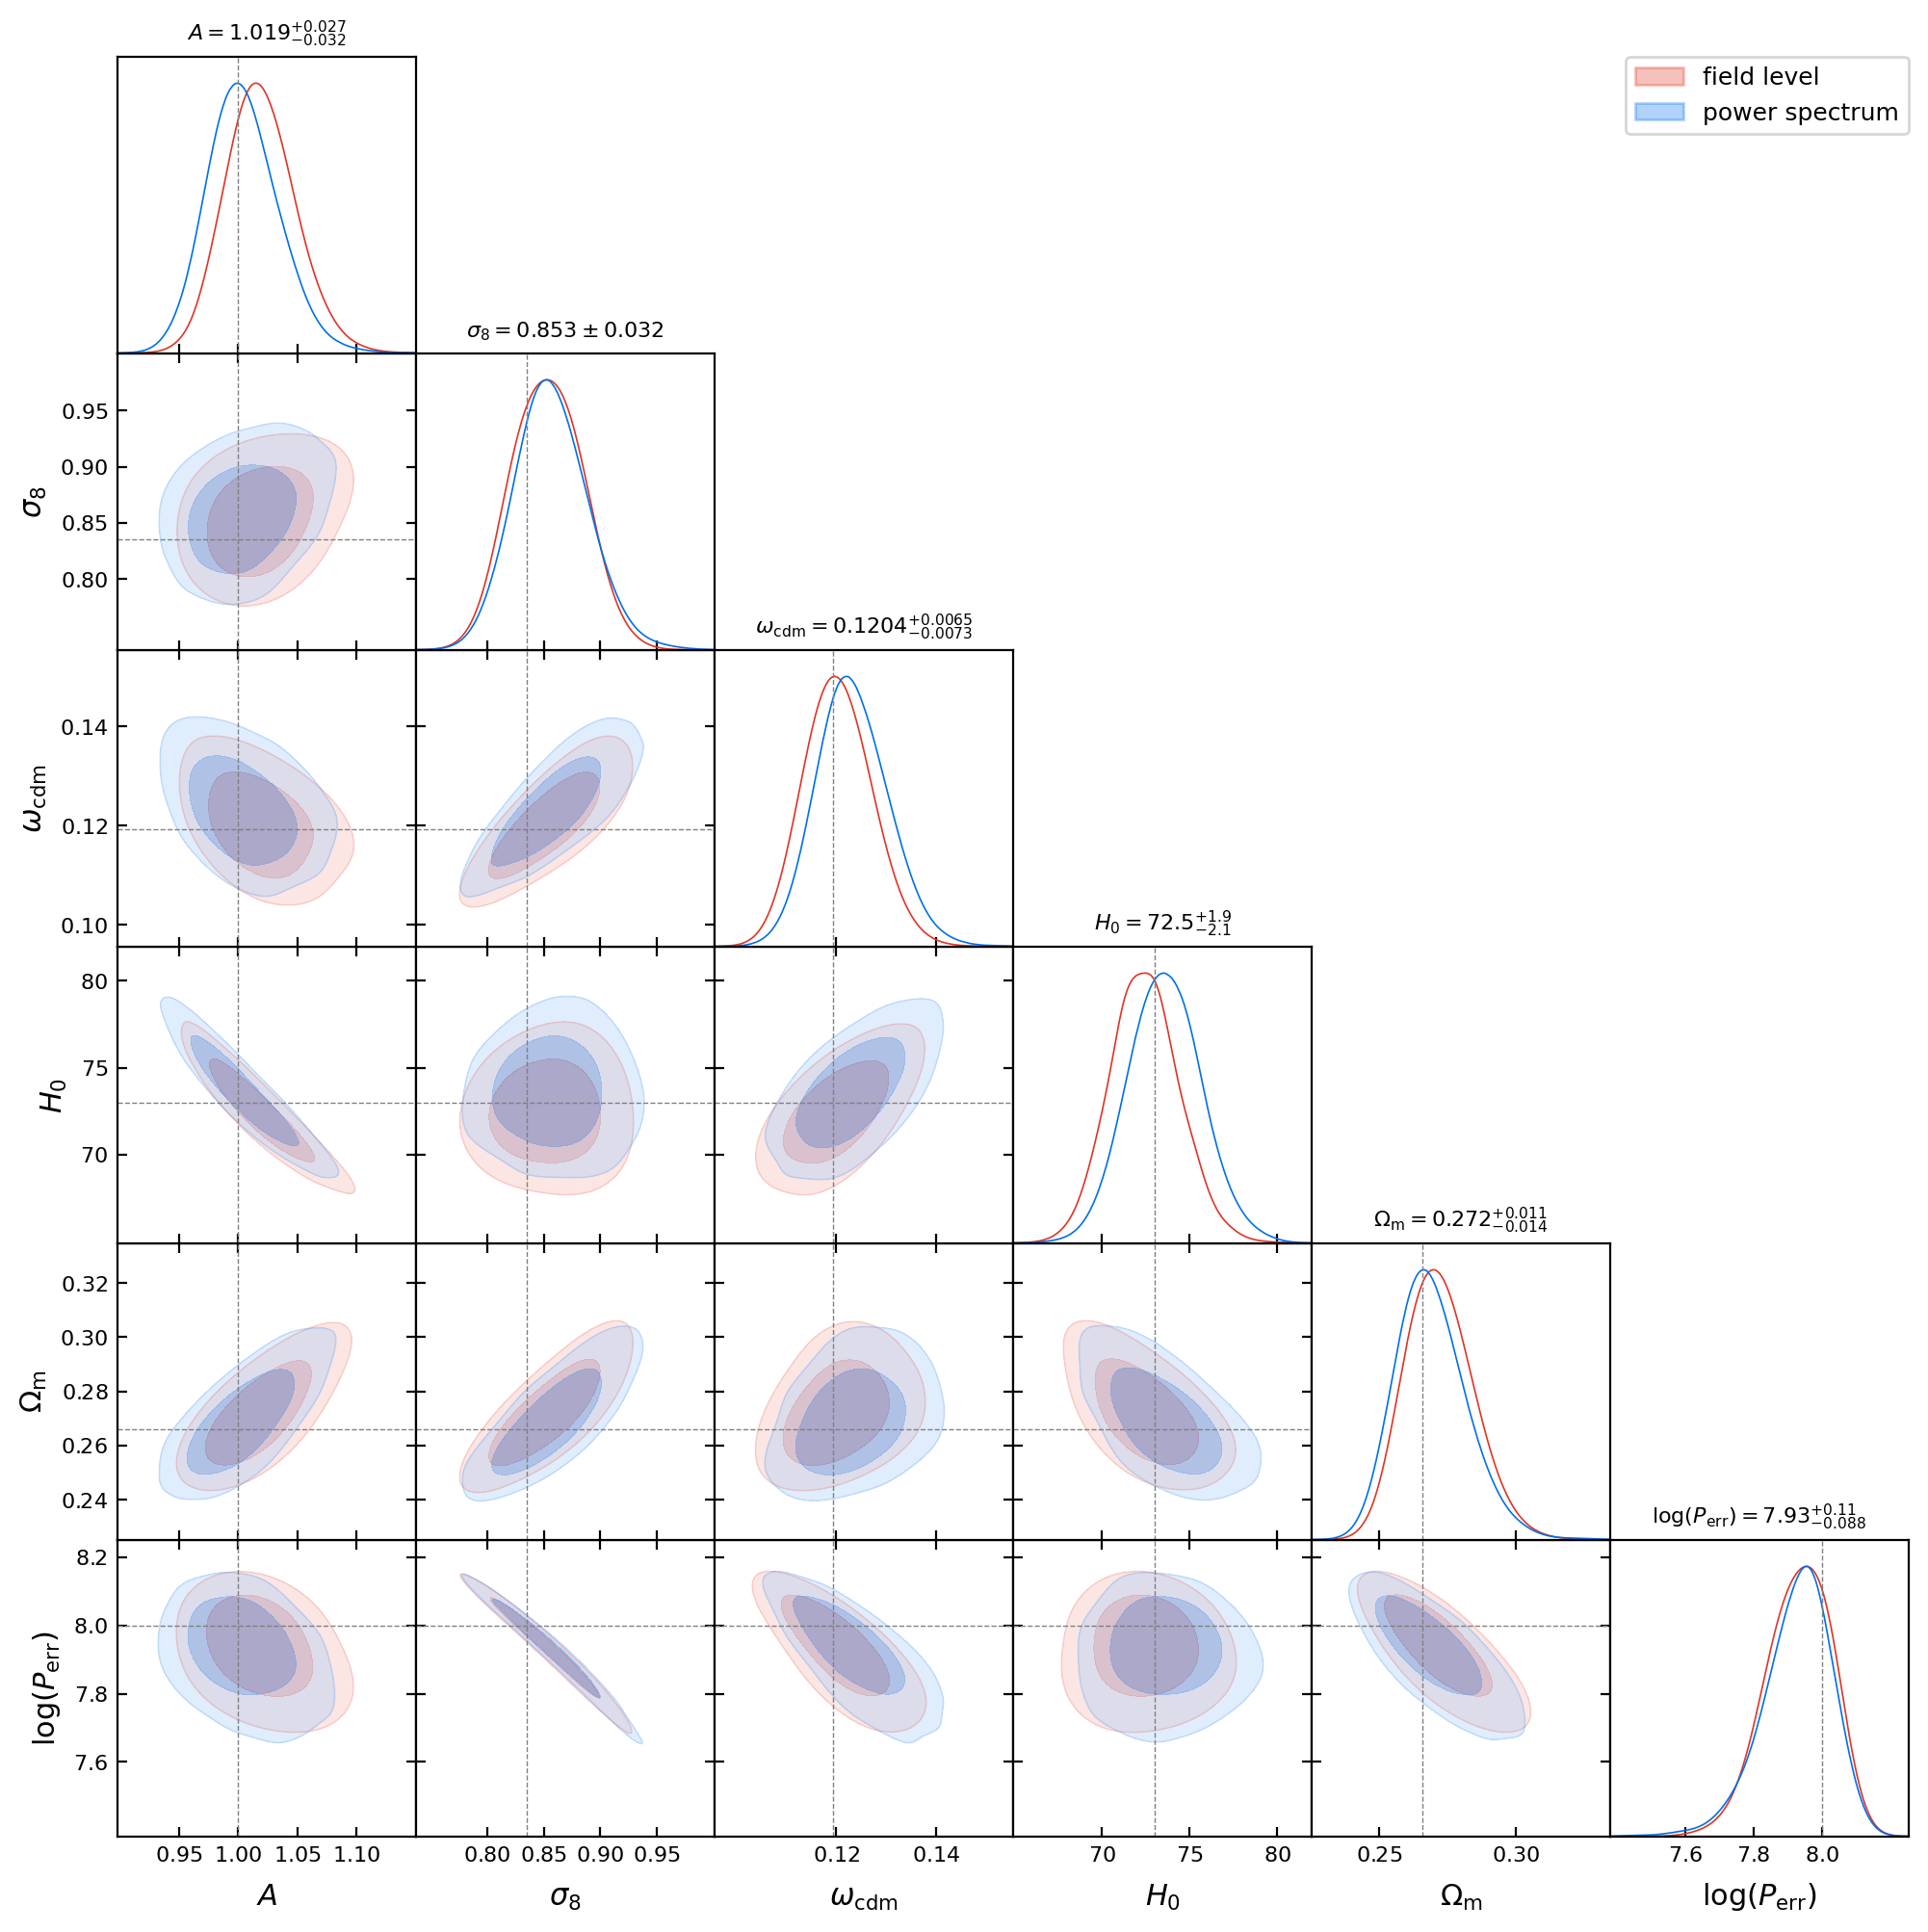

In [ ]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'log_Perr']


markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([samples[f'{name_base}'],
                 samples[f'pow_{name_base}'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')

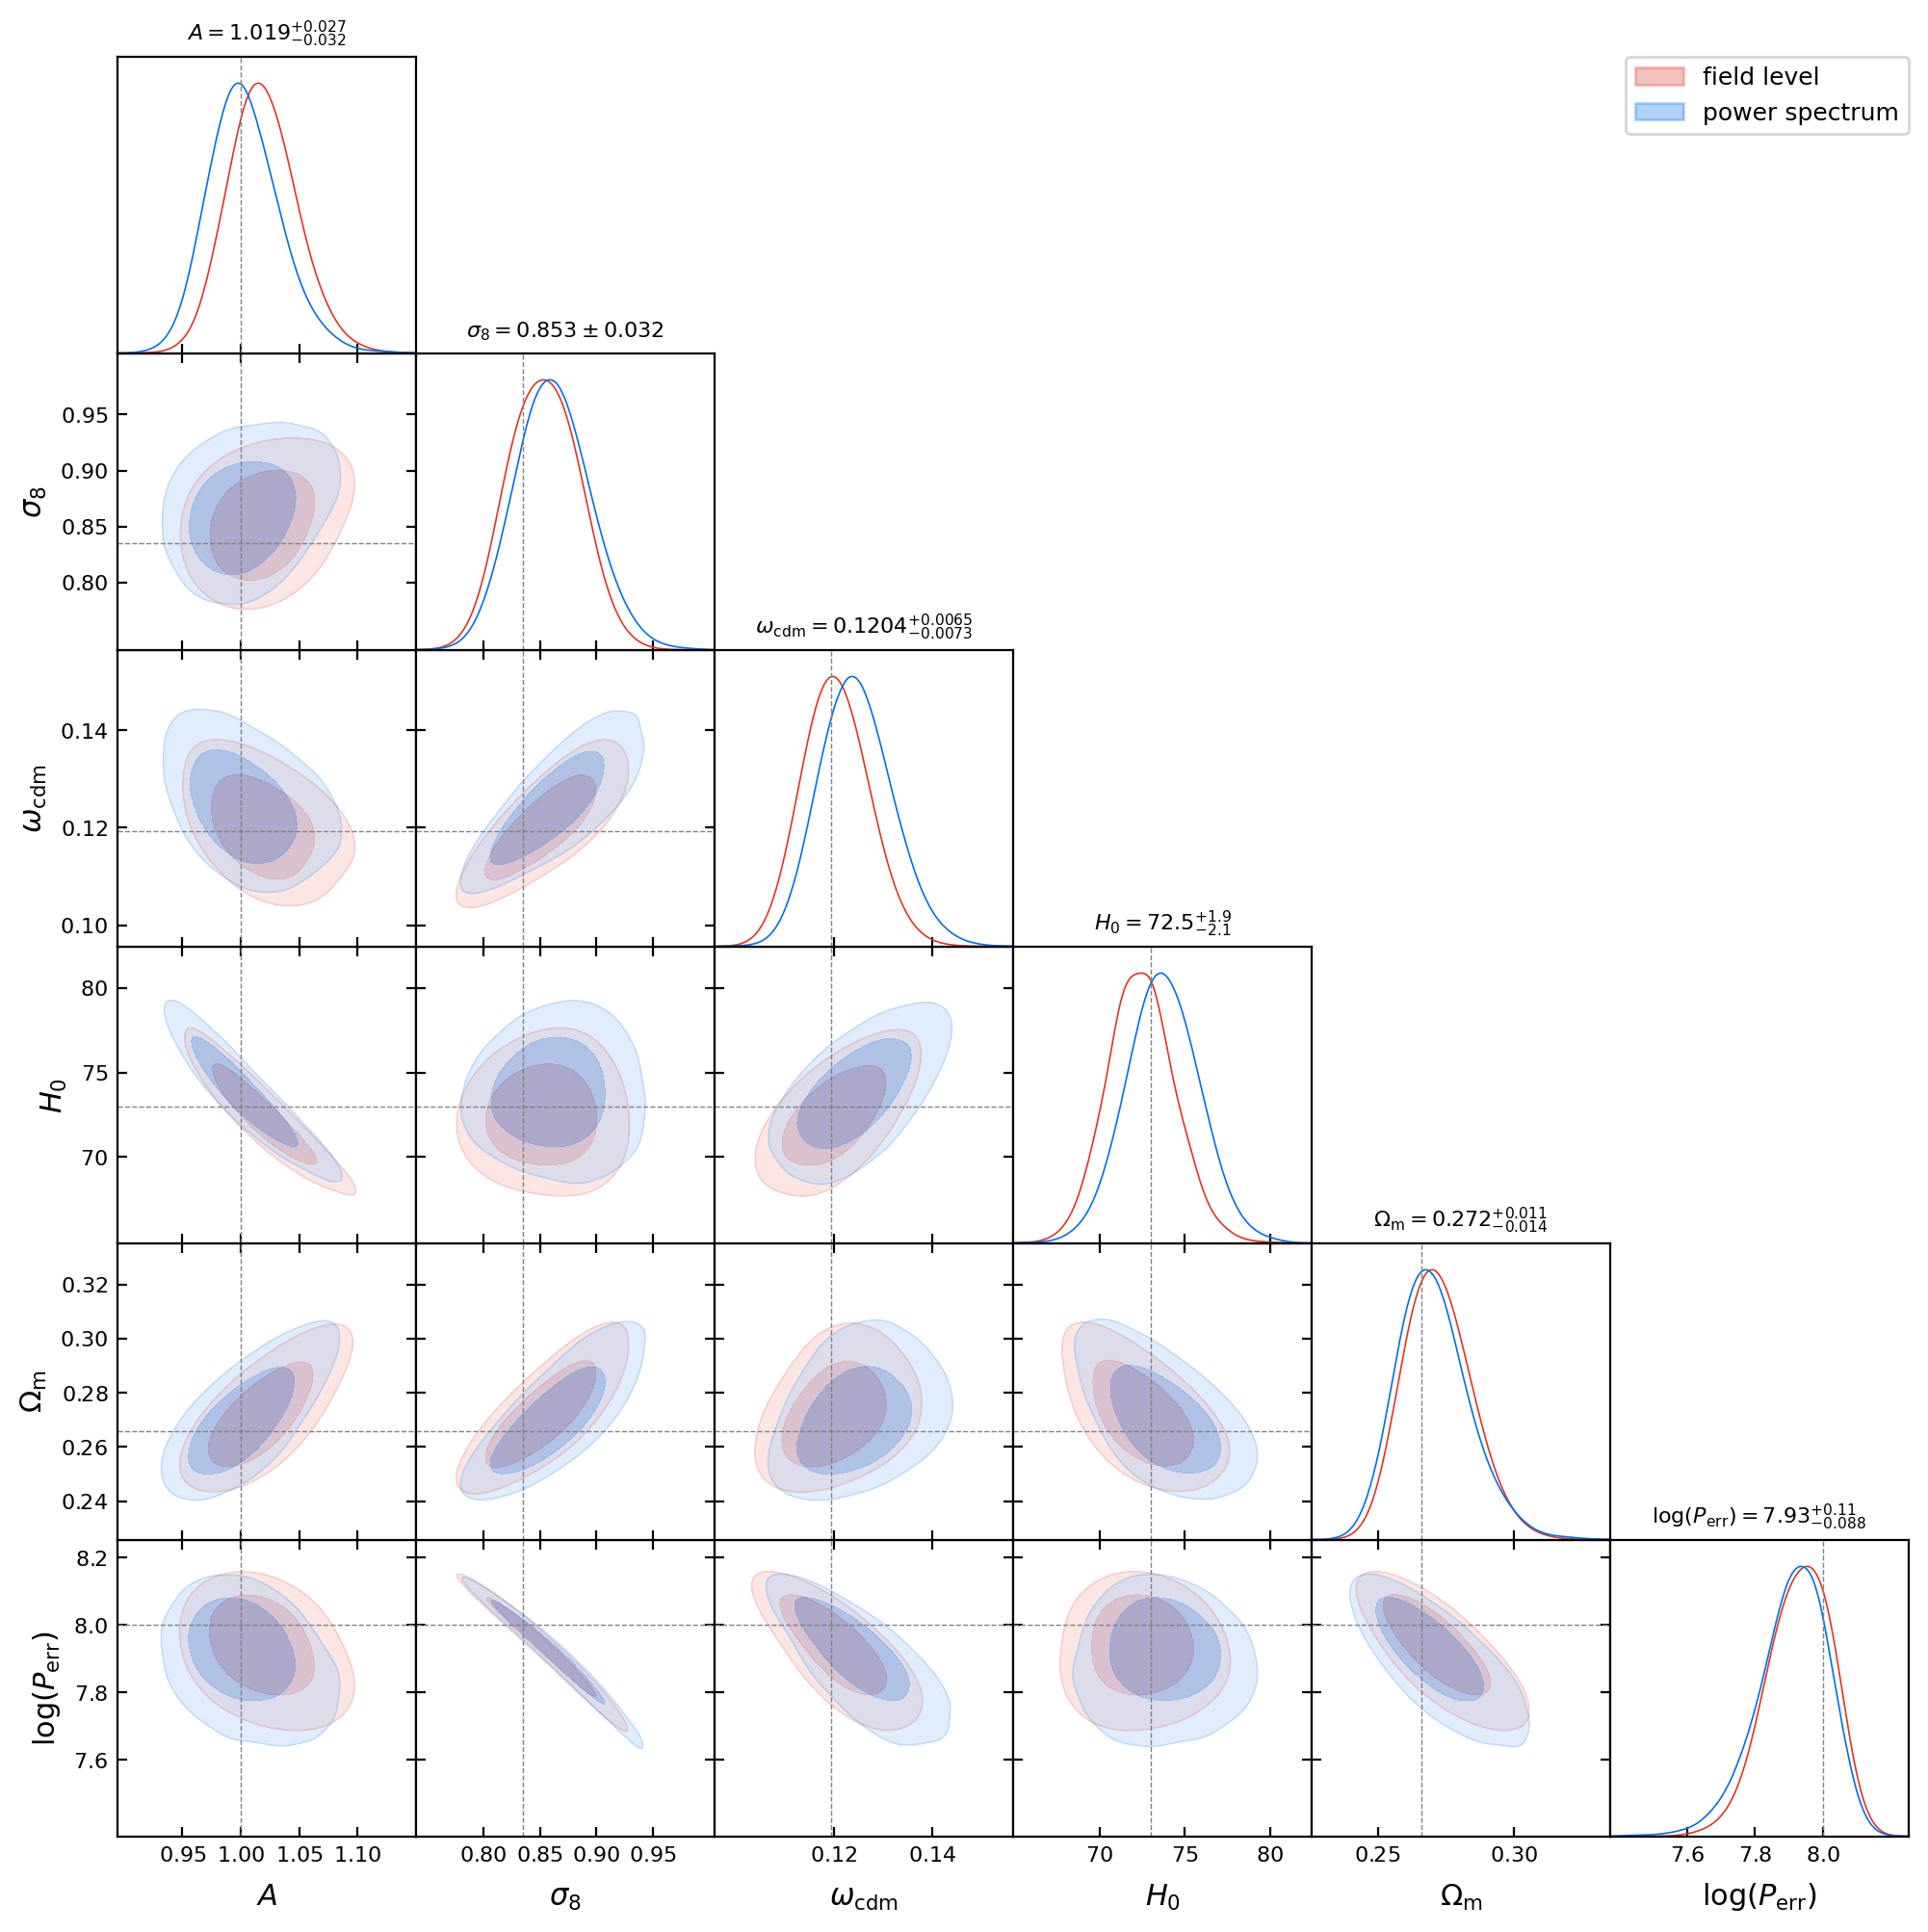

In [ ]:
%matplotlib inline

g = plots.get_subplot_plotter()

#params_contour = ['A', 'sigma8', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'H0', 'log_Perr']
#params_contour = ['A', 'sigma8', 'oc', 'log_Perr']
params_contour = ['A', 'sigma8', 'oc', 'H0', 'OM', 'log_Perr']


markers = {'A':1.0, 'sigma8':0.835, 'oc':0.11933, 'hubble':0.73, 'H0':73.0, 'OM':OM0, 'log_Perr':8.0}
    
g.triangle_plot([samples[f'{name_base}'],
                 samples[f'pow_{name_base}'],
                 ],
                params=params_contour,
                markers=markers,
                title_limit=1,
                contour_args={'alpha':0.3},
                filled=True,
                legend_loc='upper right')

### Compare to Stephen's results

/home/kakitsu/field_level/full/from_stephen/cosmo_params_rsd/pk_k0.1_A_Perr_b1_H0_omch2_linear_2Gpc_rsd_cosmopower_discrete.1.txt
/home/kakitsu/field_level/full/from_stephen/cosmo_params_rsd/pk_k0.1_A_Perr_b1_H0_omch2_linear_2Gpc_rsd_cosmopower_discrete.2.txt
/home/kakitsu/field_level/full/from_stephen/cosmo_params_rsd/pk_k0.1_A_Perr_b1_H0_omch2_linear_2Gpc_rsd_cosmopower_discrete.3.txt
/home/kakitsu/field_level/full/from_stephen/cosmo_params_rsd/pk_k0.1_A_Perr_b1_H0_omch2_linear_2Gpc_rsd_cosmopower_discrete.4.txt
/home/kakitsu/field_level/full/from_stephen/cosmo_params_rsd/pk_k0.1_A_Perr_b1_H0_omch2_linear_2Gpc_rsd_cosmopower_discrete.5.txt
/home/kakitsu/field_level/full/from_stephen/cosmo_params_rsd/pk_k0.1_A_Perr_b1_H0_omch2_linear_2Gpc_rsd_cosmopower_discrete.6.txt
/home/kakitsu/field_level/full/from_stephen/cosmo_params_rsd/pk_k0.1_A_Perr_b1_H0_omch2_linear_2Gpc_rsd_cosmopower_discrete.7.txt
/home/kakitsu/field_level/full/from_stephen/cosmo_params_rsd/pk_k0.1_A_Perr_b1_H0_omch2_li

Removed 0.5 as burn in


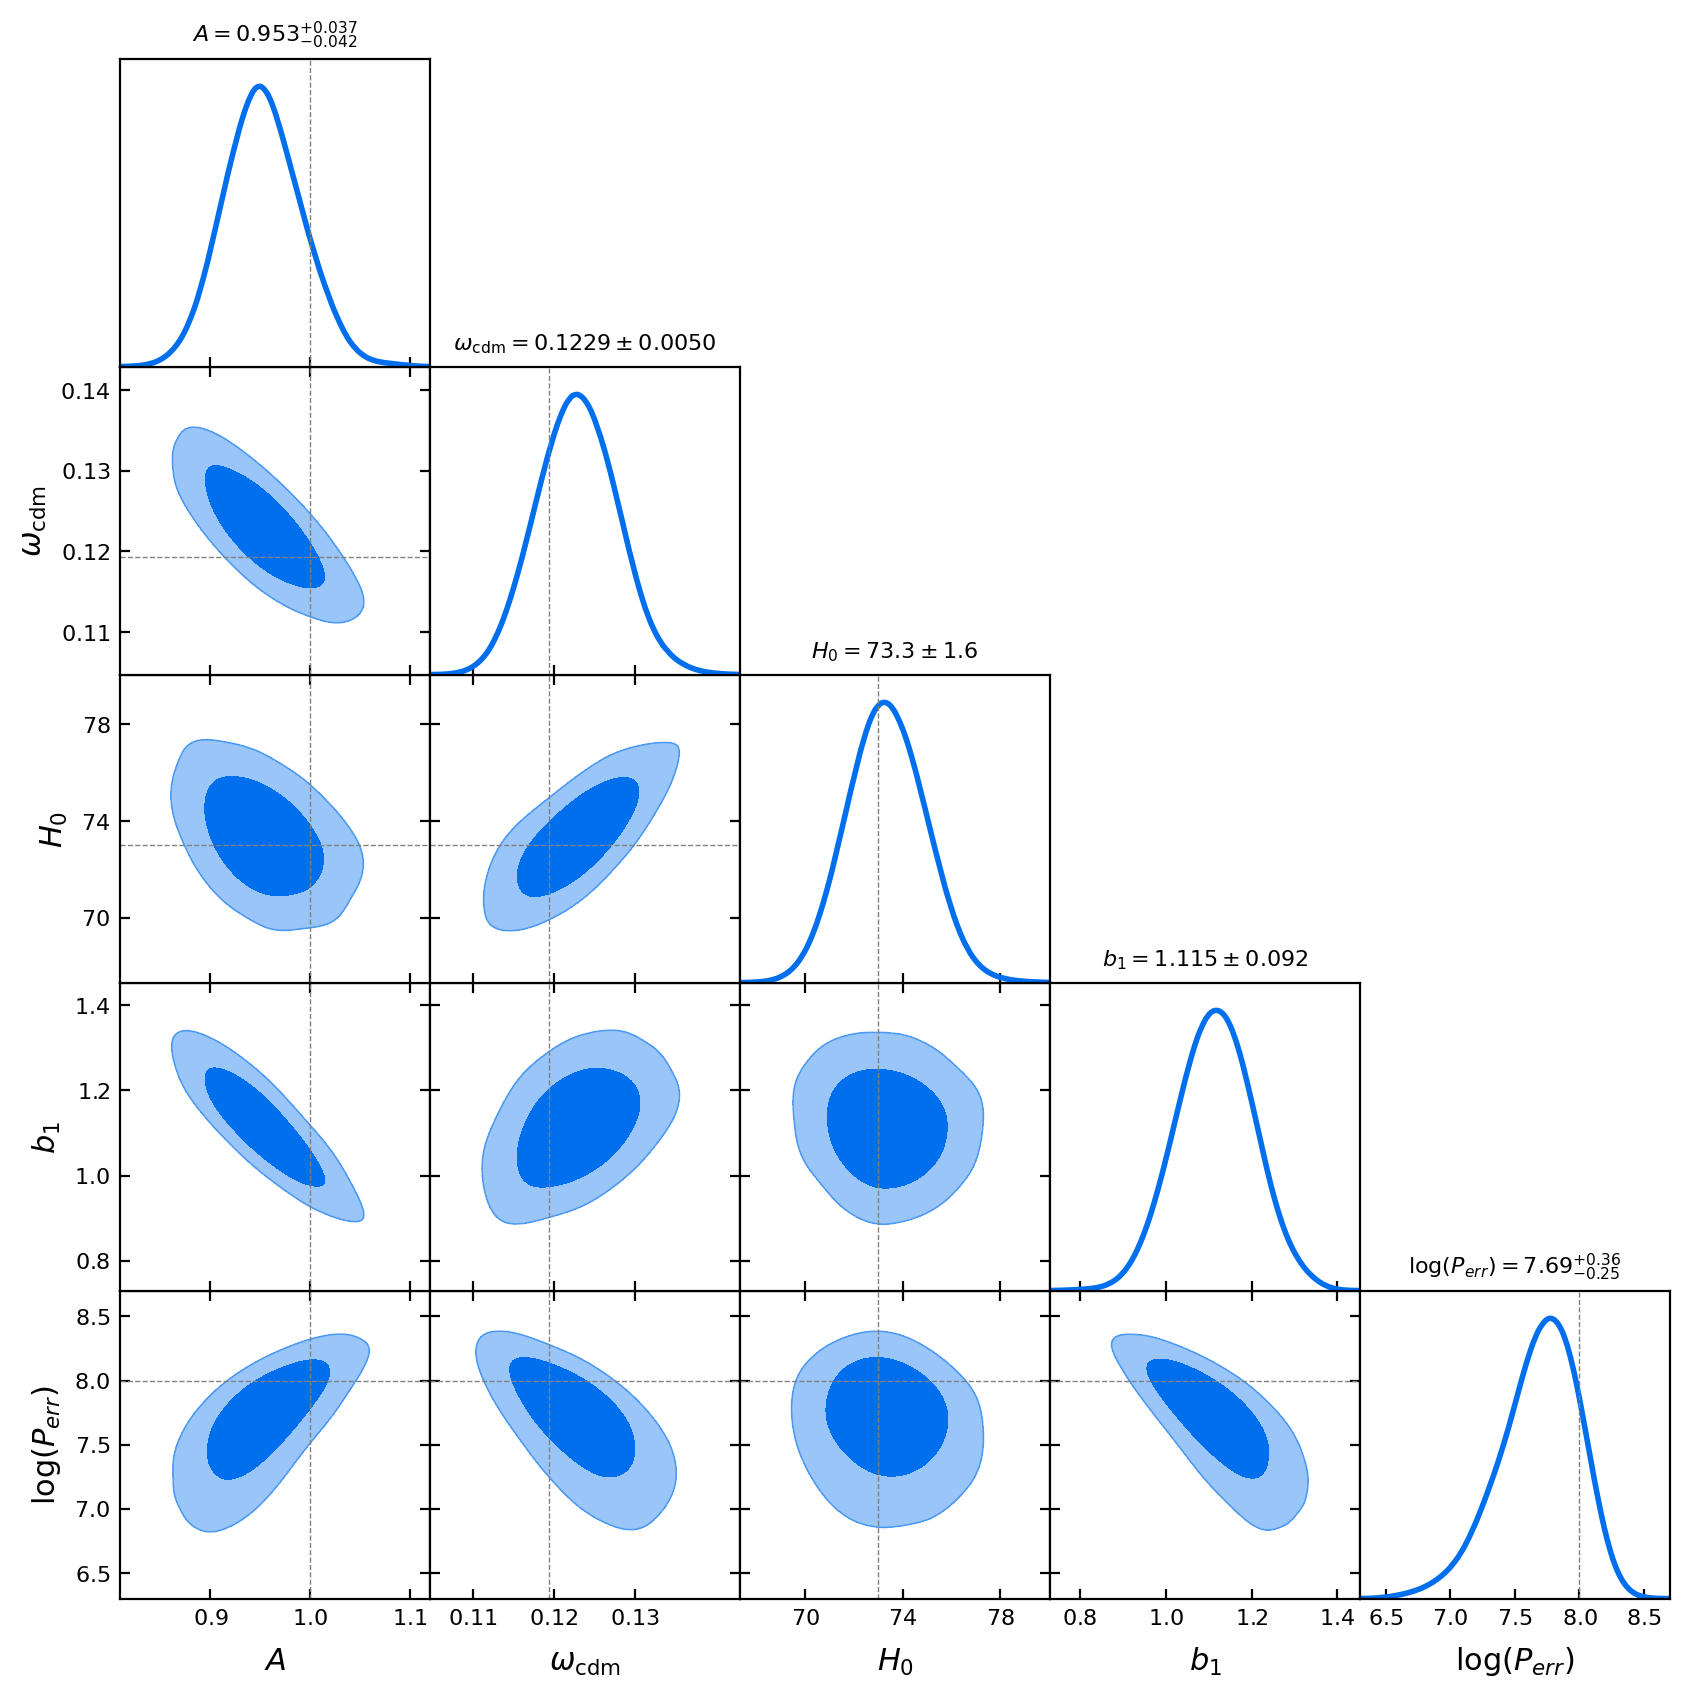

In [54]:
### load the data
import os
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

root_pk = '/home/kakitsu/field_level/full/from_stephen'

#which_model = 'updated_cosmopower/pk_k0.1_A_Perr_H0_linear_2Gpc_real_cosmopower'
#which_model = 'cosmopower/pk_k0.1_A_Perr_omch2_linear_2Gpc_real_cosmopower'
#which_model = 'pk_k0.1_A_Perr_linear_2Gpc_real'
#which_model = 'updated_cosmopower/pk_k0.1_A_Perr_H0_linear_2Gpc_real_cosmopower'
which_model = 'cosmo_params_rsd/pk_k0.1_A_Perr_b1_H0_omch2_linear_2Gpc_rsd_cosmopower_discrete'


samples_tmp = loadMCSamples(os.path.abspath(f'{root_pk}/{which_model}'),
                            settings={'ignore_rows':0.5}, no_cache=True)

#params_tmp = ['A', 'H0', 'logPerr']
#params_tmp = ['A', 'omch2', 'H0', 'logPerr']
#params_tmp = ['A', 'H0', 'logPerr']
params_tmp = ['A', 'omch2', 'H0', 'b1', 'logPerr']

gdplot = gdplt.get_subplot_plotter()

gdplot.triangle_plot(samples_tmp,
                     params_tmp,
                     filled=True,
                     title_limit=1,contour_lws=2,
                     markers = {'A': 1.0, 'b1':2.0, 'omch2':omega_c, 'H0':73.0, 'logPerr':8.0})

In [57]:
tmp_dict = np.array([samples_tmp['A'],
                     samples_tmp['omch2'],
                     samples_tmp['H0'],
                     samples_tmp['b1'] + 1.0,
                     samples_tmp['logPerr'],
                    ])

#params_contour = ['A', 'H0', 'log_Perr']
#params_contour = ['A', 'oc', 'H0', 'log_Perr']

#params_contour = ['A', 'H0', 'log_Perr']
params_contour = ['A','oc','H0','b1' ,'log_Perr']


for param in params_contour:
    labels += [name_to_label(param)]

samples[f'stephen_pow_{name_base}'] = MCSamples(samples=tmp_dict.T,
                                                names=params_contour,
                                                labels=labels,
                                                label='power spectrum from Stephen')


Removed no burn in


In [24]:
gdplot.triangle_plot([samples[f'{name_base}'],
                      samples[f'pow_{name_base}'],
                      samples[f'stephen_pow_{name_base}'],
                      ],
                     params=params_contour,
                     markers={'A':1.0, 'b1':2.0, 'oc':0.11933, 'H0':73.0, 'log_Perr':8.0}, 
                     title_limit=1,contour_lws=1,
                     contour_args={'alpha':0.3},
                     filled=True,
                     legend_loc='upper right')


KeyError: 'pow_cosmo_2000.0_z0.5_s1995_gauss_512_768_128_Gaussian_8.0_128_2006_gauss_128_192_128_A_oc_hubble_log_Perr_A_oc_hubble_log_Perr_0.1_0.8'

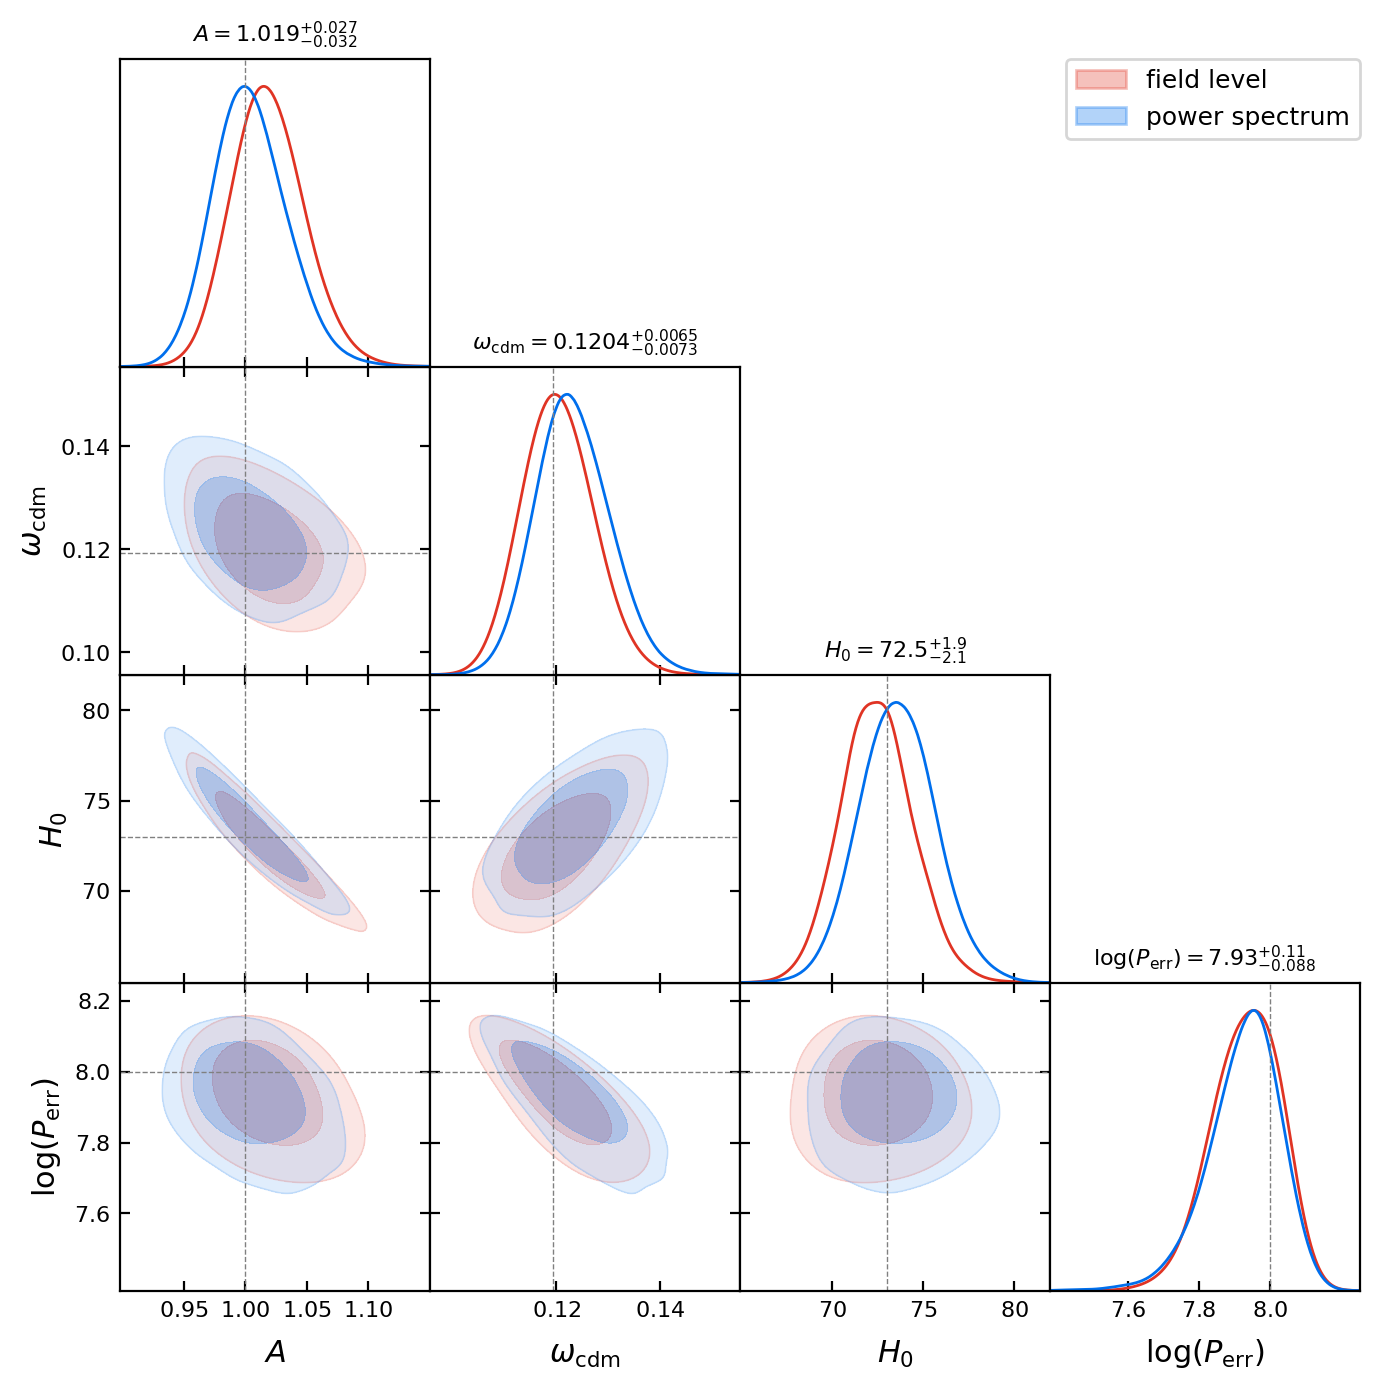

In [ ]:
gdplot.triangle_plot([samples[f'{name_base}'],
                      samples[f'pow_{name_base}'],
                      #samples[f'stephen_pow_{name_base}'],
                      ],
                     params=params_contour,
                     markers={'A':1.0, 'b1':2.0, 'oc':0.11933, 'H0':73.0, 'log_Perr':8.0}, 
                     title_limit=1,contour_lws=1,
                     contour_args={'alpha':0.3},
                     filled=True,
                     legend_loc='upper right')


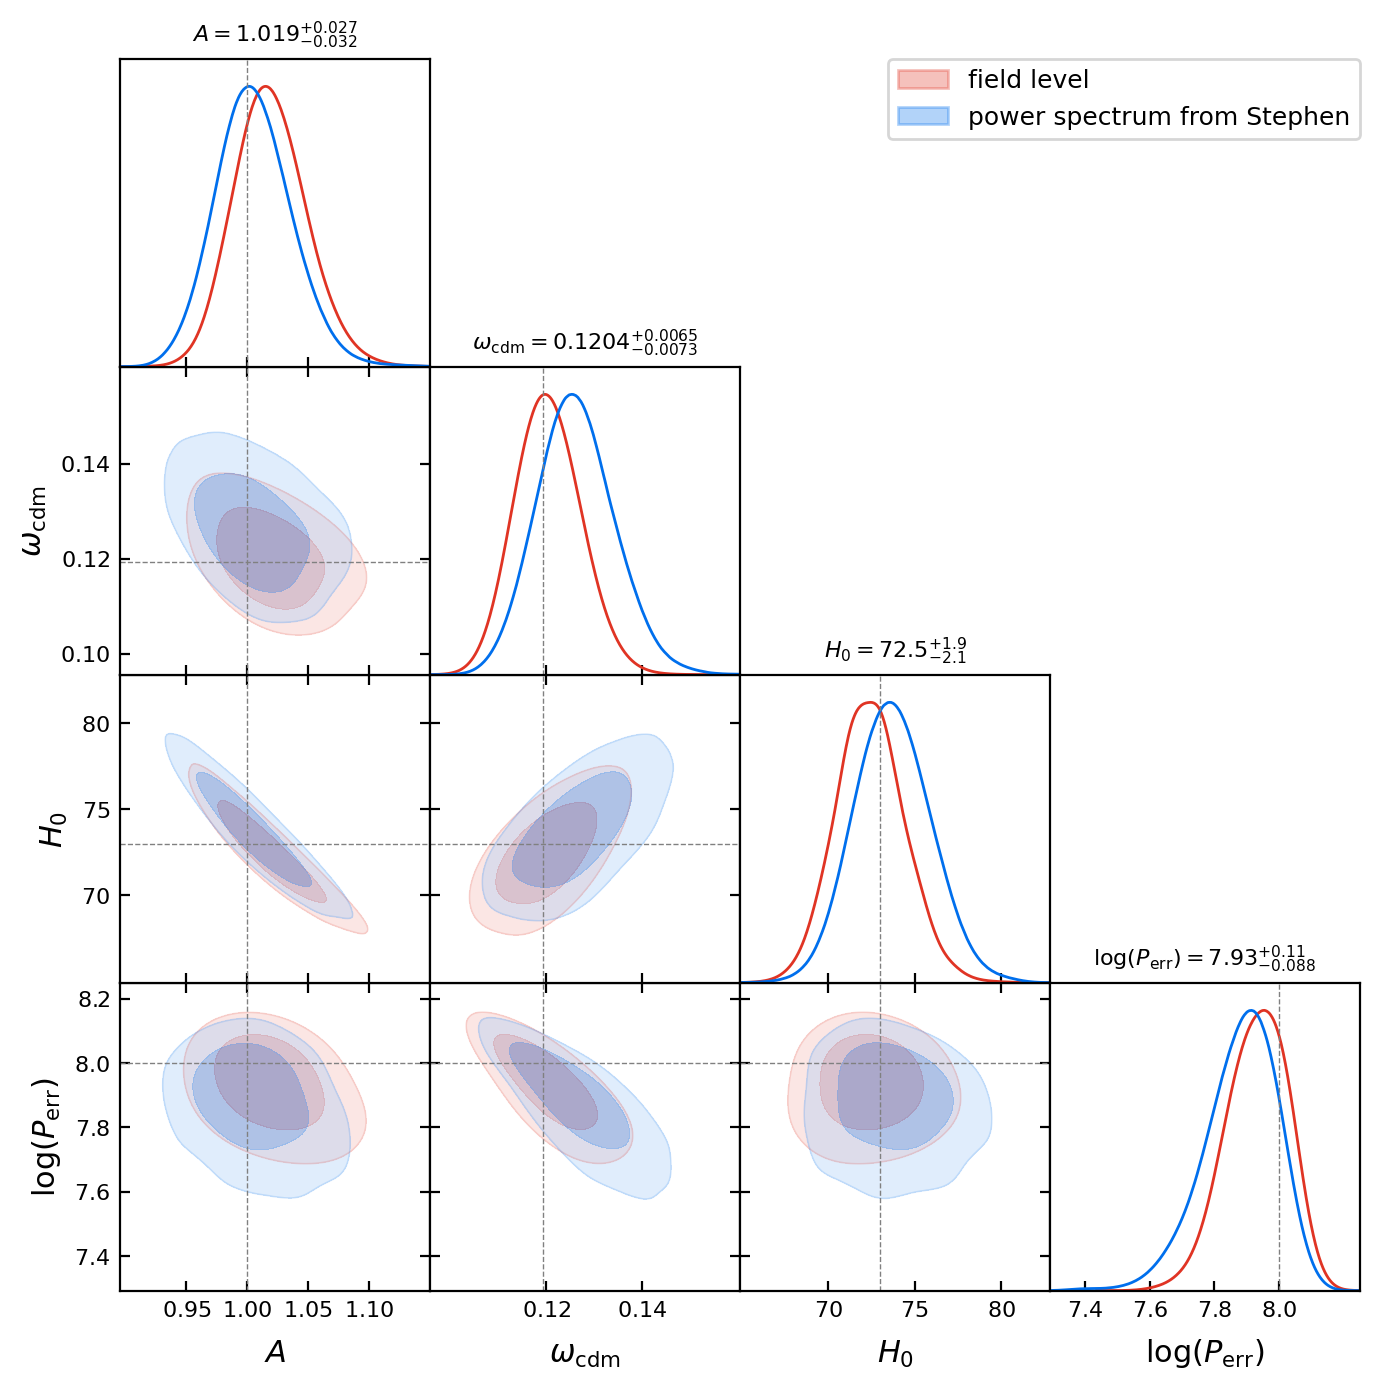

In [ ]:
gdplot.triangle_plot([samples[f'{name_base}'],
                      #samples[f'pow_{name_base}'],
                      samples[f'stephen_pow_{name_base}'],
                      ],
                     params=params_contour,
                     markers={'A':1.0, 'b1':2.0, 'oc':0.11933, 'H0':73.0, 'log_Perr':8.0}, 
                     title_limit=1,contour_lws=1,
                     contour_args={'alpha':0.3},
                     filled=True,
                     legend_loc='upper right')


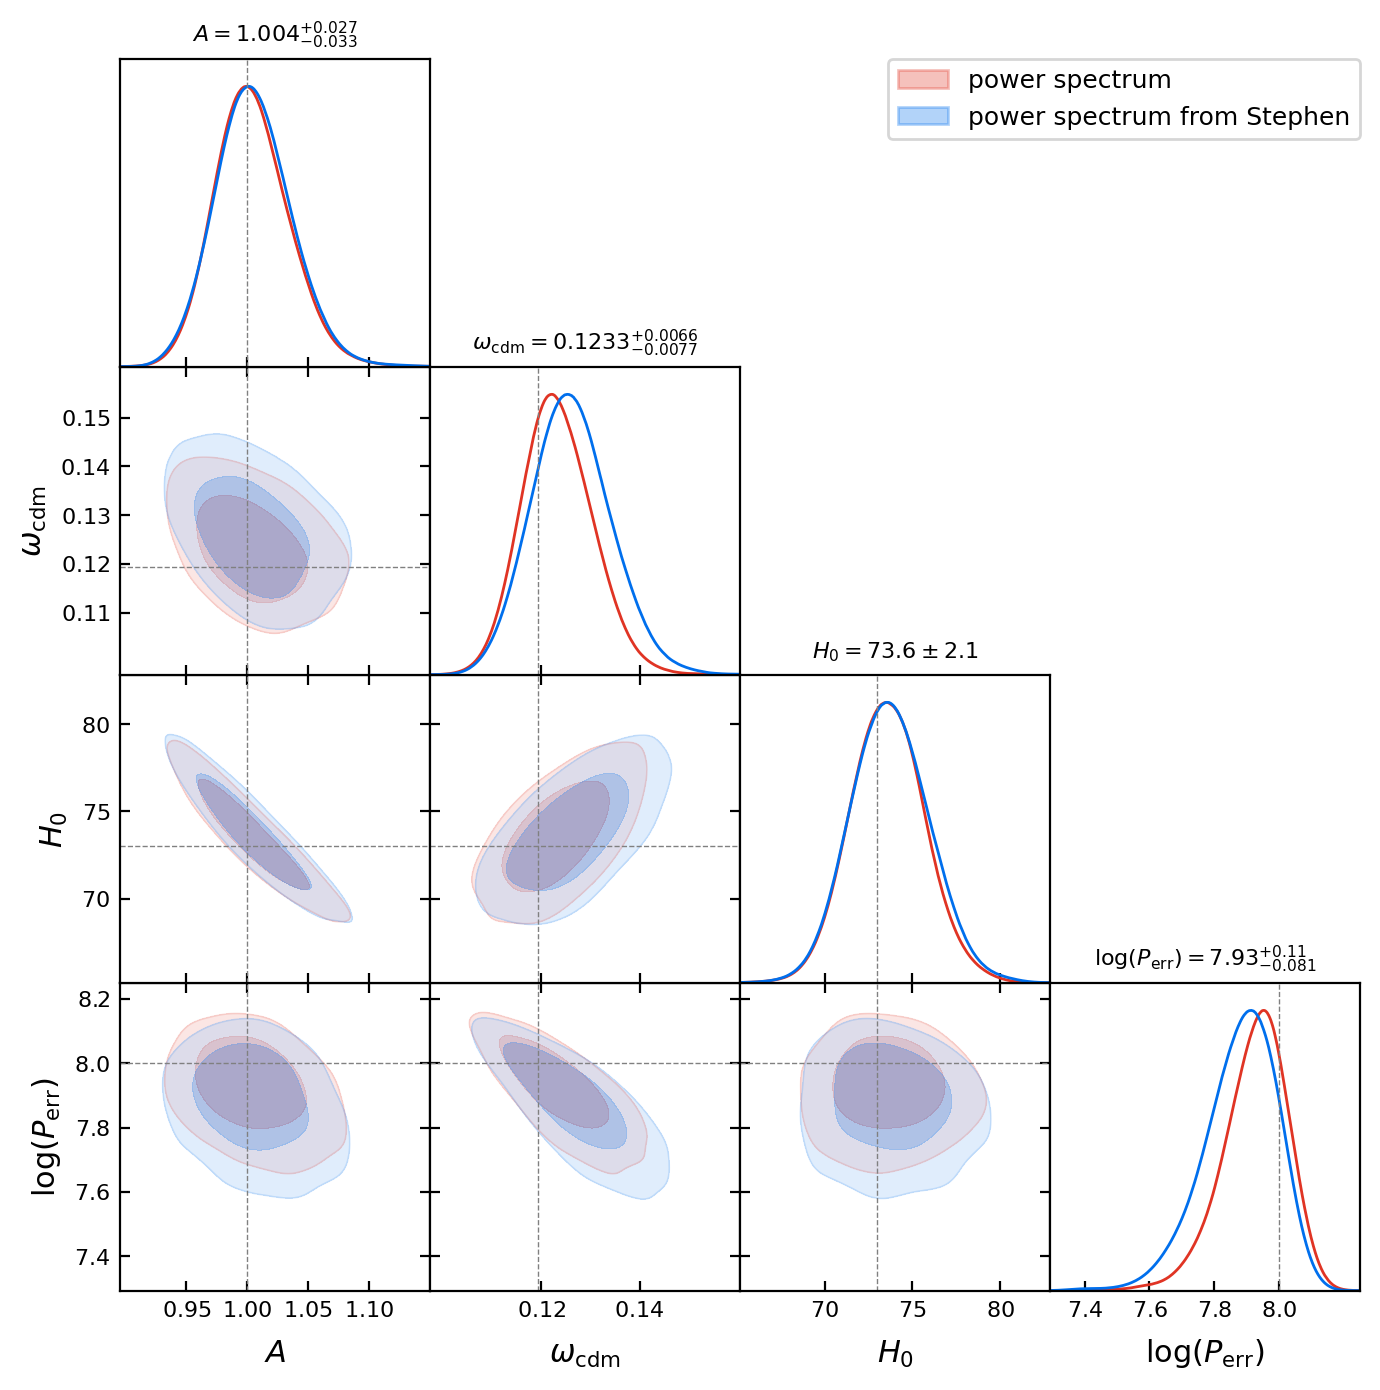

In [ ]:
gdplot.triangle_plot([#samples[f'{name_base}'],
                      samples[f'pow_{name_base}'],
                      samples[f'stephen_pow_{name_base}'],
                      ],
                     params=params_contour,
                     markers={'A':1.0, 'b1':2.0, 'oc':0.11933, 'H0':73.0, 'log_Perr':8.0}, 
                     title_limit=1,contour_lws=1,
                     contour_args={'alpha':0.3},
                     filled=True,
                     legend_loc='upper right')
